----
# Wnt Medulloblastoma Manuscript Revisions
L.Richards  
December 2018    

---

---
## 1.0 Overview of Reviewer Comments
---

### 1.1 Number of cells does not match

"Figure 3. In response to my previous suggestions related to addressing subclonality in WNT and non-WNT tumors, the authors have now incorporated 10x single-cell RNA-sequencing data for 5 cell line models (n=1 WNT, n=3 Group 3, and n=1 Group 4). This data is presented in revised Figure 3a,b and Supp Figure 5. Based on the data shown, the authors claim to have identified ‘a small population of cells in Group 3 and 4 MBs (that) exhibited (a) high Wnt signature compared to the bulk population’. However, when inspecting Supp Figure 5 in detail, there are a few important details that are misleading and perhaps incorrectly interpreted. First, it seems that the number of cells per sample shown in Supp Figure 5 does not match the number of cells per sample shown in the t-SNE plots in Figure 3. Was this done intentionally?"
> Re-loaded data and cell counts are correct   
---
### 1.2 Reviewer dislikes the use of Z-scores

"Second, it appears that the ‘Wnt_signature scores’ have been z-score normalized, an approach that would increase the likelihood of a given subpopulation taken from any bulk sample to look as though it has a ‘high score’ for a given signature, in this case the ‘Wnt_signature’ – in essence making it possible to identify ‘positive’ cells for any signature in any population."


---
### 1.3 Sparse data leads to low / absenst expression of many genes

"What’s equally confounding about the data shown in Supp Figure 5 is that in non-WNT tumors, the few cells that have high scores for the ‘Wnt_signature’ only express a few of the listed signature genes. Even looking at the single WNT tumor in this Supp Figure, it seems that the cells scoring highest for the ‘Wnt_signature’ are likewise negative for many of the genes included in the heatmap and those with the highest scores don’t look massively different than lower scoring cells in terms of Wnt pathway gene expression status. Overall, despite commending the efforts of the authors for generating this single-cell data and including it here, this reviewer does not find these data overly convincing for the reasons mentioned above."


---
### 1.4 Map transcriptonal profiles of TGP +/- samples to single cell data

"Using a Wnt reporter (7XTCF-GFP, TGP), the authors identify a rare population of TGP+ cells in non-Wnt MBs and show these cells have reduced expression of Bmi1 and Sox2, decreased proliferation and self-renewal, and reduced ability to form tumors in mice. Has any attempt been made to determine the transcriptome-wide differences between TGP+ and TGP- cells in the context of these experiments to validate the TGP+ subpopulation as having an active WNT signaling program? Mapping such transcriptional data back to the single-cell data presented in Figure 3a,b would be an informative validation experiment for inferences rendered from single-cell data and downstream functional studies presented throughout Figure 3."


---
## 2.0 Analysis
---


---
### 2.2 Calculate functional enrichment with GSVA
---

GSVA required two inputs: gene expression data (as a matrix) and collection of gene sets (as a list), in this case gene signatures describing 4 medullo subgroups and 1 signature for the KEGG Wnt pathway. The gsva() function also offers the following three other unsupervised gene set enrichment methods that calculate single sample pathway summaries of expression and which can be selected through the method argument: plage, z-score, ssgsea, gsva.

**Gene signatures can be found here:**  
https://docs.google.com/spreadsheets/d/1bi3wwzgs-CiGIrqao--raF06YBjipw_m2SjXDE49h9I/edit?usp=sharing

** References: **
> GSVA Bioconductor Page: https://bioconductor.org/packages/release/bioc/html/GSVA.html  
> GSVA Documentation: https://bioconductor.org/packages/release/bioc/vignettes/GSVA/inst/doc/GSVA.pdf  

---

In [ ]:
suppressPackageStartupMessages({
    library(Seurat)
    #library(GSEABase)
    library(GSVA)
    #library(Biobase)
    library(RColorBrewer)
    library(parallel)
    #library(GSA)
    library(qvalue)
})

## load data, object called 'Wnt_medullo'

load("~/pughlab/projects/SinghLab_scMedullo/data/Wnt_medullo_noSHH.rdata")
dat <- data.matrix(Wnt_medullo@scale.data)
dat[1:10, 1:10]
dim(dat)

## load gene sigantures from Singh Lab
load("~/pughlab/projects/SinghLab_scMedullo/data/geneSets_SinghLab.Rdata")
str(gene.sets)

## run GSVA enrichment scoring

EnrichmentScores <- gsva(expr = dat, 
                         gset.idx.list = gene.sets, 
                         method = "gsva",
                         min.sz = 2, 
                         max.sz = Inf, 
                         mx.diff = TRUE, 
                         verbose = T, 
                         parallel.sz = 10
                        )

save(EnrichmentScores, file = "EnrichmentScores_ScaledData.RData")

dat <- data.matrix(Wnt_medullo@data)

EnrichmentScores <- gsva(expr = dat, 
                         gset.idx.list = gene.sets, 
                         method = "gsva",
                         min.sz = 2, 
                         max.sz = Inf, 
                         mx.diff = TRUE, 
                         verbose = T, 
                         parallel.sz = 10
                        )

save(EnrichmentScores, file = "EnrichmentScores_Data.RData")

---
### 2.3 Calculate gene signature enrichment with AUCell
---


**References:**
> Bioconductor page: https://bioconductor.org/packages/release/bioc/html/AUCell.html    
> AUCell Tutorial:  https://bioconductor.org/packages/release/bioc/vignettes/AUCell/inst/doc/AUCell.html  

In [ ]:
#if (!requireNamespace("BiocManager", quietly = TRUE))
#    install.packages("BiocManager")
#BiocManager::install("AUCell", version = "3.8")

suppressPackageStartupMessages({
    library(Seurat)
    library(AUCell)
    library(RColorBrewer)
    library(NMF)
})

load("~/pughlab/projects/SinghLab_scMedullo/data/Wnt_medullo_noSHH.rdata")
exprMatrix <- as.matrix(Wnt_medullo@data)
dat[1:10, 1:10]
dim(exprMatrix)

load("~/pughlab/projects/SinghLab_scMedullo/data/geneSets_SinghLab.Rdata")
str(gene.sets)

# build gene-expressoin rankings for each cell

cells_rankings <- AUCell_buildRankings(exprMatrix, nCores=1, plotStats=TRUE)
save(cells_rankings, file="cells_rankings.RData")

#calculate enrichment for gene signatures (AUC)

cells_AUC <- AUCell_calcAUC(gene.sets, cells_rankings)
save(cells_AUC, file="cells_AUC.RData")

set.seed(123)
par(mfrow=c(2,3)) 

pdf("signature_histograms.pdf")
cells_assignment <- AUCell_exploreThresholds(cells_AUC, 
                                             plotHist=TRUE, 
                                             assign=TRUE) 
dev.off

#load the tSNE from the file

tsne_coords <- Wnt_medullo@dr$tsne@cell.embeddings
selectedThresholds <- getThresholdSelected(cells_assignment)

pdf("test.pdf")
par(mfrow=c(2,3))

AUCell_plotTSNE(tSNE = tsne_coords, 
                exprMat = exprMatrix, 
                cellsAUC = cells_AUC, 
                thresholds = selectedThresholds
               )

dev.off()

In [ ]:
#### USE increase aucMAX####

suppressPackageStartupMessages({
    library(Seurat)
    library(AUCell)
    library(RColorBrewer)
    library(NMF)
})

load("~/pughlab/projects/SinghLab_scMedullo/data/Wnt_medullo_noSHH.rdata")
exprMatrix <- as.matrix(Wnt_medullo@data)
exprMatrix[1:10, 1:10]
dim(exprMatrix)

load("~/pughlab/projects/SinghLab_scMedullo/data/geneSets_SinghLab.Rdata")
str(gene.sets)

# build gene-expressoin rankings for each cell

cells_rankings <- AUCell_buildRankings(exprMatrix, nCores=1, plotStats=TRUE)
save(cells_rankings, file="cells_rankings.RData") 

#calculate enrichment for gene signatures (AUC)

cells_AUC <- AUCell_calcAUC(gene.sets, cells_rankings, aucMaxRank = ceiling(0.25 * nrow(cells_rankings)))
save(cells_AUC, file="cells_AUC.RData")

set.seed(123)
par(mfrow=c(2,3)) 

pdf("signature_histograms.pdf")
cells_assignment <- AUCell_exploreThresholds(cells_AUC, 
                                             plotHist=TRUE, 
                                             assign=TRUE) 


dev.off()

#load the tSNE from the file

tsne_coords <- Wnt_medullo@dr$tsne@cell.embeddings
selectedThresholds <- getThresholdSelected(cells_assignment)

pdf("test.pdf")
par(mfrow=c(2,3))

AUCell_plotTSNE(tSNE = tsne_coords, 
                exprMat = exprMatrix, 
                cellsAUC = cells_AUC, 
                thresholds = selectedThresholds
               )

dev.off()

---
## 3.0 Cluster data with scClustViz
---

In [ ]:
suppressMessages(library(scales))
suppressMessages(library(viridis))
suppressMessages(library(RColorBrewer))
suppressMessages(library(cluster))
suppressMessages(library(pbapply))
suppressMessages(library(Seurat))
suppressMessages(library(optparse))
suppressMessages(library(dplyr))
suppressMessages(library(plyr))
suppressMessages(library(scClustViz))

In [ ]:
#Run tSNE with first 11 PCs and perplex = 30

load("~/pughlab/projects/SinghLab_scMedullo/data/Wnt_medullo_noSHH.rdata")

Wnt_medullo <- RunTSNE(Wnt_medullo, dims.use = 1:11, perplexity = 30)

In [ ]:
#Cluster with range of resolutions from 0.2 - 1.0

resVal <- seq(0.2, 1.0, by = 0.1)

for (i in 1:length(resVal)){
    
    print(resVal[i])
    print(Sys.time())
    Wnt_medullo <- FindClusters(Wnt_medullo,
                     reduction.type="pca",
                     dims.use=1:11,
                     k.param=30,
                     print.output=F,
                     resolution=resVal[i],
                     algorithm=3,
                     n.start=100,
                     n.iter=100,
                     save.SNN=T
                    )
}

In [ ]:
#save clustering results for input to scClustViz
filename <- "WntMedullo_ClustVizInput.RData"
print(filename)
save(Wnt_medullo, file=filename)

In [ ]:
#Run scClusViz and save results

data_for_scClustViz <- readFromSeurat(Wnt_medullo)

DE_for_scClustViz <- clusterWiseDEtest(data_for_scClustViz, 
                                       testAll = TRUE, 
                                       exponent = exp(1), 
                                       pseudocount = 1,
                                       FDRthresh = 0.01, 
                                       threshType = "dDR", 
                                       dDRthresh = 0.15,
                                       logGERthresh = 1
                                      )

file.name.2 <- "WntMedullo_scClustViz_Results.RData"
print(file.name.2)

save(data_for_scClustViz,
     DE_for_scClustViz, 
     file=file.name.2
     ) 

In [ ]:
#manually review the Shiny page for each of the solutions

library(scClustViz)
setwd("~/Desktop/Samwise/projects/projects/SinghLab_scMedullo/scClustViz/")

sample <- 
file <- "WntMedullo_scClustViz_Results.RData"

runShiny(filePath=file)

---
## 4.0 Redo QC on cells
---

Some clusters from the scClustViz results seem to be driven by low gene number (some as low as 122 genes)...bump up the cell cutoff to 500 genes minimum and remove the MAD filtering for this category. so filtering is as follows:

1) Remove cells with >30% percent mito    
2) Remove cells with <500 genes    

 3) Remove cells with >3MAD nUMI    
4) Gene filtering = Remove genes in total library detected in less than 1% of cells in the smallest library    

In [ ]:
suppressMessages(library(Seurat))

In [ ]:
filtered.dat <- read.table('/mnt/work1/users/pughlab/projects/SinghLab_scMedullo/data/Dropbead_rawCounts_aggregate.txt', header = T)
dim(filtered.dat) 
meta <- read.table('/mnt/work1/users/pughlab/projects/SinghLab_scMedullo/data/metadata_aggregate.txt', header = T)
dim(meta)

#replace the - with a .
#colnames(filtered.dat)[1:20]
rownames(meta) <- gsub("-", ".", rownames(meta))
head(rownames(meta))

In [ ]:
Wnt_medullo <- CreateSeuratObject(raw.data = filtered.dat, 
                                  min.cells = 0, 
                                  min.genes = 500, 
                                  project = "Singh",
                                 meta.data = meta
                                 )

In [ ]:
mito.genes <- grep(pattern = "^MT-", 
                   x = rownames(x = Wnt_medullo@data), 
                   value = TRUE)

percent.mito <- Matrix::colSums(Wnt_medullo@raw.data[mito.genes, ])/Matrix::colSums(Wnt_medullo@raw.data)

Wnt_medullo <- AddMetaData(object = Wnt_medullo, 
                          metadata = percent.mito, 
                          col.name = "percent.mito")

Wnt_medullo <- FilterCells(object = Wnt_medullo , 
                    subset.names = c("percent.mito"), 
                    low.thresholds = c( -Inf), 
                    high.thresholds = c(0.3)
                   )

dim(Wnt_medullo@data)
dim(Wnt_medullo@meta.data)

In [ ]:
#determine doublet threshold for each library

upper.limit <- function(metric, nmads){
               cur.med <- median(log10(metric), na.rm = TRUE)
               cur.mad <- mad(log10(metric), center = cur.med, na.rm = TRUE)
               cur.med + nmads * cur.mad }

sample.names <- unique(Wnt_medullo@meta.data$Sample)

bad.cells <- c()

for (i in 1:length(sample.names)){
    
    sample <- sample.names[i]
    nmad <- 2
    df <- Wnt_medullo@meta.data[Wnt_medullo@meta.data$Sample == sample, ]
    
    #print(head(df))

    upper.UMI <- 10^upper.limit(df$nUMI, nmad)
    
    print(sample)
    print(upper.UMI)
    
    poorQ.cells <- df[df$nUMI >= upper.UMI, ]
    print(dim(poorQ.cells))
    #print(head(poorQ.cells))
    
    bad.cells <- c(bad.cells, rownames(poorQ.cells)) #50 bad cells across all samples
    
    
    }

print(length(bad.cells))

In [ ]:
#make the poor cells 0 and the good cells 1

Wnt_medullo@meta.data$Cell.Quality <- rownames(Wnt_medullo@meta.data) %in% bad.cells
Wnt_medullo@meta.data$Cell.Quality <- gsub("TRUE", 0, Wnt_medullo@meta.data$Cell.Quality)
Wnt_medullo@meta.data$Cell.Quality <- gsub("FALSE", 1, Wnt_medullo@meta.data$Cell.Quality)
Wnt_medullo@meta.data$Cell.Quality <- as.numeric(Wnt_medullo@meta.data$Cell.Quality)


Wnt_medullo <- FilterCells(object = Wnt_medullo , 
                    subset.names = c("Cell.Quality"), 
                    low.thresholds = c(0.1)
                   )

table(Wnt_medullo@meta.data$Sample)

In [ ]:
#filter genes
#1% of smallest library = min 5 cells

Wnt_medullo <- CreateSeuratObject(raw.data = Wnt_medullo@data, 
                                  min.cells = 5,
                                  min.genes = 0,
                                  project = "SinghLab",
                                 meta = Wnt_medullo@meta.data
                                 )


In [ ]:
sample.names <- unique(Wnt_medullo@meta.data$Sample)

for (i in 1:length(sample.names)){
    
        sample <- sample.names[i]
        df <- Wnt_medullo@meta.data[Wnt_medullo@meta.data$Sample == sample, ]
        print(sample)
    print(median(df$nUMI))
    print(median(df$nGene))
    print(mean(df$percent.mito))
    
}

In [ ]:
#Normalize data and scale genes

Wnt_medullo <- NormalizeData(object = Wnt_medullo, 
                            normalization.method = "LogNormalize", 
                            scale.factor = 10000)


Wnt_medullo <- FindVariableGenes(object = Wnt_medullo, 
                          mean.function = ExpMean, 
                          dispersion.function = LogVMR, 
                          x.low.cutoff = 0.0125, 
                          x.high.cutoff = 3, 
                          y.cutoff = 0.5
                         )
length(Wnt_medullo@var.genes) #4102 genes across dataset are variable

Wnt_medullo <- ScaleData(object = Wnt_medullo) #no regression performed


#PCA - top 100 PCs across all cells

Wnt_medullo <- RunPCA(object = Wnt_medullo, 
                      pc.genes = Wnt_medullo@var.genes, 
                      do.print = FALSE, 
                      #pcs.print = 1:5, 
                      #genes.print = 5,
                      pcs.compute = 100
                     )
Wnt_medullo <- ProjectPCA(object = Wnt_medullo, do.print = FALSE)

#Determine number of PCs -- choose 11 PCs to cluster with 

pdf("Wnt_medullo_elbow.pdf")
PCElbowPlot(object = Wnt_medullo,
            num.pc = 50
           
           )
dev.off()

In [ ]:
#### PLUG all this into scClustViz and recluster the new dataframe with low gene cells removed
#### Hopefully this removes some of the 

filename <- "WntMedullo_ClustVizInput_newQC.RData"
print(filename)
save(Wnt_medullo, file=filename)

#Run scClusViz and save results

data_for_scClustViz <- readFromSeurat(Wnt_medullo)

DE_for_scClustViz <- clusterWiseDEtest(data_for_scClustViz, 
                                       testAll = TRUE, 
                                       exponent = exp(1), 
                                       pseudocount = 1,
                                       FDRthresh = 0.01, 
                                       threshType = "dDR", 
                                       dDRthresh = 0.15,
                                       logGERthresh = 1
                                      )

file.name.2 <- "WntMedullo_scClustViz_Results_newQC.RData"
print(file.name.2)

save(data_for_scClustViz,
     DE_for_scClustViz, 
     file=file.name.2
     ) 

In [ ]:
#manually review the Shiny page for each of the solutions

library(scClustViz)
setwd("~/Desktop/Samwise/projects/SinghLab_scMedullo/QC/")

file <- "WntMedullo_scClustViz_Results_newQC.RData"

runShiny(filePath=file)

---
## 5.0 Revised AddModuleScore()
---

In [ ]:
library(Seurat)

load("~/pughlab/projects/SinghLab_scMedullo/data/geneSets_SinghLab.Rdata")
str(gene.sets)

load("~/pughlab/projects/SinghLab_scMedullo/QC/WntMedullo_ClustVizInput_newQC.RData")
dim(Wnt_medullo@data)
str(Wnt_medullo)

In [ ]:
#on x@data slot

Wnt_medullo <- AddModuleScore(Wnt_medullo,
                       genes.list = gene.sets,
                       n.bin = 25,
                       seed.use = 1,
                       ctrl.size = 100,
                       random.seed = 123,
                       enrich.name = names(gene.sets)
                      )

#add "ADM" to each signature name to signify the method used
colnames(Wnt_medullo@meta.data)[19:25] <- paste("AMS", colnames(Wnt_medullo@meta.data)[19:25], sep = "_")
colnames(Wnt_medullo@meta.data)[19:25] <- gsub('.{1}$', '', colnames(Wnt_medullo@meta.data)[19:25])

In [ ]:
#to perform on the scaled data, we have to replace the @data slot with @scaled.data

Wnt_medullo@data[1:10, 1:10]
Wnt_medullo@scale.data[1:10, 1:10]


test <- Wnt_medullo
(test@data)[1:10, 1:10]
(test@scale.data)[1:10, 1:10]
test@data <- test@scale.data
(test@data)[1:10, 1:10]

test <- AddModuleScore(test,
                       genes.list = gene.sets,
                       n.bin = 25,
                       seed.use = 1,
                       ctrl.size = 100,
                       random.seed = 123,
                       enrich.name = names(gene.sets)
                      )

#add "AMS" to each signature name to signify the method used
colnames(test@meta.data)[26:32] <- paste("AMS.ScaledData", colnames(test@meta.data)[26:32], sep = "_")
colnames(test@meta.data)[26:32] <- gsub('.{1}$', '', colnames(test@meta.data)[26:32])

#add to Wnt_medullo object

Wnt_medullo <- AddMetaData(Wnt_medullo, test@meta.data[ ,26:32])

In [ ]:
save(Wnt_medullo, file = "WntMedullo_newQC_scoring.RData")

---
## 6.0 Revised GSVA Scoring
---

In [ ]:
suppressPackageStartupMessages({
    library(Seurat)
    #library(GSEABase)
    library(GSVA)
    #library(Biobase)
    library(RColorBrewer)
    library(parallel)
    #library(GSA)
    library(qvalue)
})

## load data, object called 'Wnt_medullo'

dat <- data.matrix(Wnt_medullo@scale.data)
dat[1:10, 1:10]
dim(dat)

## load gene sigantures from Singh Lab
load("~/pughlab/projects/SinghLab_scMedullo/data/geneSets_SinghLab.Rdata")
str(gene.sets)

## run GSVA enrichment scoring

EnrichmentScores <- gsva(expr = dat, 
                         gset.idx.list = common, 
                         method = "gsva",
                         min.sz = 2, 
                         max.sz = Inf, 
                         mx.diff = TRUE, 
                         verbose = T, 
                         parallel.sz = 10
                        )

save(EnrichmentScores, file = "EnrichmentScores_newQC_ScaledData.RData")

ES_scaled <- t(EnrichmentScores)
colnames(ES_scaled) <- paste("GSVA.scaled", colnames(ES_scaled), sep = "_")
Wnt_medullo <- AddMetaData(Wnt_medullo, data.frame(ES_scaled))




dat <- data.matrix(Wnt_medullo@data)

EnrichmentScores <- gsva(expr = dat, 
                         gset.idx.list = gene.sets, 
                         method = "gsva",
                         min.sz = 2, 
                         max.sz = Inf, 
                         mx.diff = TRUE, 
                         verbose = T, 
                         parallel.sz = 10
                        )

save(EnrichmentScores, file = "EnrichmentScores_newQC_Data.RData")

ES_scaled <- t(EnrichmentScores)
colnames(ES_scaled) <- paste("GSVA", colnames(ES_scaled), sep = "_")
Wnt_medullo <- AddMetaData(Wnt_medullo, data.frame(ES_scaled))

---
# 7.0 Plot scores onto tSNE
---

In [55]:
library(ggplot2)
library(viridis)
library(RColorBrewer)
library(Seurat)

Warning message:
“package ‘ggplot2’ was built under R version 3.4.4”Warning message:
“package ‘viridis’ was built under R version 3.4.4”Loading required package: viridisLite
Warning message:
“package ‘viridisLite’ was built under R version 3.4.3”Warning message:
“package ‘Seurat’ was built under R version 3.4.4”Loading required package: cowplot
Warning message:
“package ‘cowplot’ was built under R version 3.4.4”
Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave

Loading required package: Matrix
Warning message:
“package ‘Matrix’ was built under R version 3.4.4”

In [2]:
load("~/Desktop/Samwise/projects/SinghLab_scMedullo/AddModuleScore/WntMedullo_newQC_scoring.RData")

In [4]:
test <- cbind(Wnt_medullo@dr$tsne@cell.embeddings, Wnt_medullo@meta.data)
head(test)

,tSNE_1,tSNE_2,nGene,nUMI,percent.mito,Num.Reads,Sample,Subgroup,Stage,Cell.Quality,⋯,GSVA.scaled_TGP,GSVA_Wnt_Subgroup,GSVA_Shh_Subgroup,GSVA_Group3_Subgroup,GSVA_Group4_Subgroup,GSVA_KEGG_Wnt_pathway,GSVA_Canonical_Wnt_pathway,GSVA_TGP,GSVA.scaled_common.WNT,AMS.ScaledData_common.WNT
AAACCTGAGTCAATAG.1,-13.27260,-18.111087,4784,29465,0.049686068,57223,BT853,WNT,Primary,1,⋯,0.39097729,0.3256479678,0.27835785,-0.5908338,0.03031065,0.012215956,-0.208159460,0.39101145,0.50153322,0.40842257
AAACCTGGTCATTAGC.1,-14.05767,-10.198292,4068,18474,0.004492801,35775,BT853,WNT,Primary,1,⋯,-0.05115957,0.0009797874,-0.01202793,-0.5552809,-0.16620604,-0.147143612,-0.284917580,-0.05116906,0.41574679,0.48676137
AAACCTGTCATTATCC.1,-39.70283,11.645087,706,1535,0.001954397,9672,BT853,WNT,Primary,1,⋯,-0.07427595,0.2811937277,0.11715624,-0.1613676,0.07946684,-0.249353509,-0.314023959,-0.07429721,-0.32134418,0.02756316
AAACCTGTCTTACCGC.1,-38.90888,-2.707165,2001,5328,0.235735736,15362,BT853,WNT,Primary,1,⋯,0.21633522,0.2438440353,0.38239835,-0.6469643,0.37134792,-0.056587106,-0.039679075,0.21632206,0.09378239,0.42095341
AAACGGGGTCACCCAG.1,-25.62579,-21.698571,5208,27359,0.040169597,49766,BT853,WNT,Primary,1,⋯,0.52854755,-0.0108689847,-0.02641130,-0.5517691,-0.28160495,-0.026951440,0.001464919,0.52851819,0.49121317,0.49620987
AAACGGGGTCTAGCGC.1,-44.67019,6.328698,2873,7758,0.140113431,39238,BT853,WNT,Primary,1,⋯,0.09623297,0.3425653101,0.08334702,-0.5050784,0.12992963,-0.001075452,0.065236512,0.09623297,-0.05413270,0.01852881


In [ ]:
pdf("~/Desktop/Singh_Sample_tSNE.pdf")


sp1 <- ggplot(test, aes(x=tSNE_1, y=tSNE_2, color=Sample)) + 
        geom_point(alpha = 0.45, size = 1.5) +  
        labs(x = "tSNE 1", y = "tSNE 2", title = "3725 cells") +
        scale_colour_brewer(palette = "Dark2") + 
        theme_bw() + 
        theme(axis.text.x = element_blank(), axis.text.y = element_blank(), axis.ticks = element_blank(),
              panel.border = element_rect(linetype = "solid", fill = NA, size = 1),
              panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
              panel.background = element_blank()) 

sp1

dev.off()

In [ ]:
sp2 <- ggplot(test, aes(x=tSNE_1, y=tSNE_2, color=AMS.ScaledData_Wnt_Subgroup)) + 
        geom_point(alpha = 0.45, size = 1.5) +  
         scale_colour_gradientn(colours = rev(brewer.pal(11, "RdBu")), limits = c(-1,1),name = "Wnt Subgroup Score") +
        labs(x = "tSNE 1", y = "tSNE 2", title = "3725 cells") +
        theme_bw() + 
        theme(axis.text.x = element_blank(), axis.text.y = element_blank(), axis.ticks = element_blank(),
              panel.border = element_rect(linetype = "solid", fill = NA, size = 1),
              panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
              panel.background = element_blank())
sp2

In [ ]:
sp3 <- ggplot(test, aes(x=tSNE_1, y=tSNE_2, color=GSVA_Wnt_Subgroup)) + 
        geom_point(alpha = 0.45, size = 1.5) +  
         scale_colour_gradientn(colours = rev(brewer.pal(11, "RdBu")),name = "Wnt Subgroup  GSVA Score") +
        labs(x = "tSNE 1", y = "tSNE 2", title = "3725 cells") +
        theme_bw() + 
        theme(axis.text.x = element_blank(), axis.text.y = element_blank(), axis.ticks = element_blank(),
              panel.border = element_rect(linetype = "solid", fill = NA, size = 1),
              panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
              panel.background = element_blank())
sp3

In [ ]:
rev(brewer.pal(11, "RdBu"))

---
# 8.0 Compare signature scoring methods
---

Conclustions - there is good correlation between the different gene signatures, with the exception of TGP that looks kind of weird. Likely because this signature is very small and is hard to get a robust signature score for...only 6 gene


In [ ]:
library("ggpubr")
library("gridExtra")

In [ ]:
pdf("~/Desktop/GSVA_AMS_comparison.pdf")

par(mfrow=c(3,3))

a <- ggscatter(test, 
          x = "AMS.ScaledData_Wnt_Subgroup", 
          y = "GSVA.scaled_Wnt_Subgroup", 
          add = "reg.line", 
          add.params = list(color = "red", fill = "darkgrey", cex = 1),
          conf.int = TRUE, 
          cor.coef = TRUE, 
          cor.method = "pearson",
          xlab = "AddModuleScore()", 
          ylab = "GSVA Enrichment Score",
          size = 0.1,
          title = "Wnt Subgroup (r= 0.81, p < 2.2e-16)",
          color = "black"
         )

b <- ggscatter(test, 
          x = "AMS.ScaledData_Shh_Subgroup", 
          y = "GSVA.scaled_Shh_Subgroup", 
          add = "reg.line", 
          add.params = list(color = "red", fill = "darkgrey", cex = 1),
          conf.int = TRUE, 
          cor.coef = TRUE, 
          cor.method = "pearson",
          xlab = "AddModuleScore()", 
          ylab = "GSVA Enrichment Score",
          size = 0.1,
          title = "Shh Subgroup (r= 0.82, p < 2.2e-16)",
          color = "black"
         )

c <- ggscatter(test, 
          x = "AMS.ScaledData_Group3_Subgroup", 
          y = "GSVA.scaled_Group3_Subgroup", 
          add = "reg.line", 
          add.params = list(color = "red", fill = "darkgrey", cex = 1),
          conf.int = TRUE, 
          cor.coef = TRUE, 
          cor.method = "pearson",
          xlab = "AddModuleScore()", 
          ylab = "GSVA Enrichment Score",
          size = 0.1,
          title = "Group3 Subgroup (r= 0.91, p < 2.2e-16)",
          color = "black"
         )

d <- ggscatter(test, 
          x = "AMS.ScaledData_Group4_Subgroup", 
          y = "GSVA.scaled_Group4_Subgroup", 
          add = "reg.line", 
          add.params = list(color = "red", fill = "darkgrey", cex = 1),
          conf.int = TRUE, 
          cor.coef = TRUE, 
          cor.method = "pearson",
          xlab = "AddModuleScore()", 
          ylab = "GSVA Enrichment Score",
          size = 0.1,
          title = "Group4 Subgroup (r= 0.78, p < 2.2e-16)",
          color = "black"
         )


e <- ggscatter(test, 
          x = "AMS.ScaledData_KEGG_Wnt_pathway", 
          y = "GSVA.scaled_KEGG_Wnt_pathway", 
          add = "reg.line", 
          add.params = list(color = "red", fill = "darkgrey", cex = 1),
          conf.int = TRUE, 
          cor.coef = TRUE, 
          cor.method = "pearson",
          xlab = "AddModuleScore()", 
          ylab = "GSVA Enrichment Score",
          size = 0.1,
          title = "KEGG Wnt Pathway (r= 0.77, p < 2.2e-16)",
          color = "black"
         )

g <- ggscatter(test, 
          x = "AMS.ScaledData_Canonical_Wnt_pathway", 
          y = "GSVA.scaled_Canonical_Wnt_pathway", 
          add = "reg.line", 
          add.params = list(color = "red", fill = "darkgrey", cex = 1),
          conf.int = TRUE, 
          cor.coef = TRUE, 
          cor.method = "pearson",
          xlab = "AddModuleScore()", 
          ylab = "GSVA Enrichment Score",
          size = 0.1,
          title = "Canonical Wnt Pathway (r= 0.74, p < 2.2e-16)",
          color = "black",
         font.label = c(2, "plain", "black")
         )

h <- ggscatter(test, 
          x = "AMS.ScaledData_TGP", 
          y = "GSVA.scaled_TGP", 
          add = "reg.line", 
          add.params = list(color = "red", fill = "darkgrey", cex = 1),
          conf.int = TRUE, 
          cor.coef = TRUE, 
          cor.method = "pearson",
          xlab = "AddModuleScore()", 
          ylab = "GSVA Enrichment Score",
          size = 0.1,
          title = "TGP (r= 0.69, p < 2.2e-16)",
          color = "black"
         )

grid.arrange(a,b,c,d,e,g,h, ncol = 3)


dev.off()

In [5]:
plot.cor <- function(x, y, title){
    
    p.cor <- cor(x, y,method = "spearman")
    
    plot(x, 
         y,
         cex = 0.1,
         xlab = "AddModuleScore()",
         ylab = "GSVA Enrichment Score",
         main = title,
         col = "black"
     )
    
    abline(lm(y~x), 
       col="red",
       lty = 1,
       lwd = 3
      )
    
    legend("bottomright",
      c(paste0("r = ", round(p.cor, 2), ", p < 2.2e-16")),
       bty = "n",
      cex = 1
      )
}






In [15]:
SOX2 <- Wnt_medullo@scale.data[rownames(Wnt_medullo@scale.data) == "SOX2", ]
head(SOX2)
BMI1 <- Wnt_medullo@scale.data[rownames(Wnt_medullo@scale.data) == "BMI1", ]
head(BMI1)

AXIN2 <- Wnt_medullo@scale.data[rownames(Wnt_medullo@scale.data) == "AXIN2", ]
head(AXIN2)

AAACCTGAGTCAATAG.1 AAACCTGGTCATTAGC.1 AAACCTGTCATTATCC.1 AAACCTGTCTTACCGC.1 
        -0.3214374         -0.3214374         -0.3214374         -0.3214374 
AAACGGGGTCACCCAG.1 AAACGGGGTCTAGCGC.1 
        -0.3214374         -0.3214374

AAACCTGAGTCAATAG.1 AAACCTGGTCATTAGC.1 AAACCTGTCATTATCC.1 AAACCTGTCTTACCGC.1 
        -0.6348695         -0.6348695         -0.6348695         -0.6348695 
AAACGGGGTCACCCAG.1 AAACGGGGTCTAGCGC.1 
         1.0472631         -0.6348695

AAACCTGAGTCAATAG.1 AAACCTGGTCATTAGC.1 AAACCTGTCATTATCC.1 AAACCTGTCTTACCGC.1 
        -0.1570402         -0.1570402         -0.1570402         -0.1570402 
AAACGGGGTCACCCAG.1 AAACGGGGTCTAGCGC.1 
        -0.1570402         -0.1570402

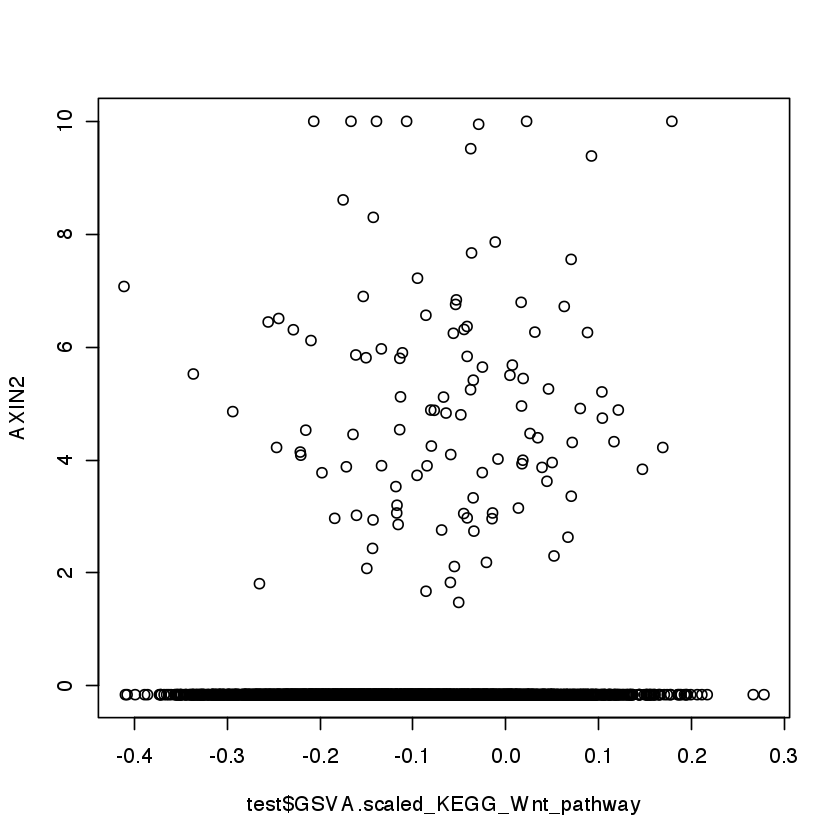

In [16]:
plot(test$GSVA.scaled_KEGG_Wnt_pathway, AXIN2)

In [9]:
plot.cor(test$AMS.ScaledData_Wnt_Subgroup, Wnt@, "Wnt Subgroup")

   [[ suppressing 3725 column names ‘AAACCTGAGTCAATAG.1’, ‘AAACCTGGTCATTAGC.1’, ‘AAACCTGTCATTATCC.1’ ... ]]


6 x 3725 sparse Matrix of class "dgCMatrix"
                                                                               
RP11-34P13.7  .         .         . . .         . . .         . . .         . .
FO538757.2    .         0.4326841 . . .         . . 0.2967529 . . .         . .
AP006222.2    0.5180897 0.4326841 . . 0.7403416 . . 0.2967529 . . .         . .
RP4-669L17.10 .         .         . . .         . . .         . . .         . .
RP5-857K21.4  .         .         . . .         . . .         . . .         . .
RP11-206L10.9 .         .         . . .         . . .         . . 0.5505856 . .
                                                                        
RP11-34P13.7  . . .         . . . . . . .         . .        . .        
FO538757.2    . . .         . . . . . . .         . .        . .        
AP006222.2    . . 0.2759969 . . . . . . 0.8701023 . 1.185821 . 0.4519851
RP4-669L17.10 . . .         . . . . . . .         . .        . .        
RP5-857K21.4  . . .         . .

In [6]:
pdf("~/Desktop/GSVA_AMS_comparison_spearman.pdf")

par(mfrow=c(2,2))

plot.cor(test$AMS.ScaledData_Wnt_Subgroup, test$GSVA.scaled_Wnt_Subgroup, "Wnt Subgroup")
plot.cor(test$AMS.ScaledData_Shh_Subgroup, test$GSVA.scaled_Shh_Subgroup, "Shh Subgroup")
plot.cor(test$AMS.ScaledData_Group3_Subgroup, test$GSVA.scaled_Group3_Subgroup, "Group 3 Subgroup")
plot.cor(test$AMS.ScaledData_Group4_Subgroup, test$GSVA.scaled_Group4_Subgroup, "Group 4 Subgroup")
plot.cor(test$AMS.ScaledData_KEGG_Wnt_pathway, test$GSVA.scaled_KEGG_Wnt_pathway, "KEGG Wnt Pathway")
plot.cor(test$AMS.ScaledData_Canonical_Wnt_pathway, test$GSVA.scaled_Canonical_Wnt_pathway, "Canonical Wnt Pathway")
plot.cor(test$AMS.ScaledData_TGP, test$GSVA.scaled_TGP, "TGP")
plot.cor(test$AMS.ScaledData_Wnt_Subgroup, ttest$GSVA.scaled_KEGG_Wnt_pathway, "TGP")

dev.off()



pdf 
  2

In [8]:
pdf("~/Desktop/GSVA_AMS_comparison.pdf")

par(mfrow=c(2,2))

plot.cor(test$AMS.ScaledData_Wnt_Subgroup, test$GSVA.scaled_Wnt_Subgroup, "Wnt Subgroup")
plot.cor(test$AMS.ScaledData_Shh_Subgroup, test$GSVA.scaled_Shh_Subgroup, "Shh Subgroup")
plot.cor(test$AMS.ScaledData_Group3_Subgroup, test$GSVA.scaled_Group3_Subgroup, "Group 3 Subgroup")
plot.cor(test$AMS.ScaledData_Group4_Subgroup, test$GSVA.scaled_Group4_Subgroup, "Group 4 Subgroup")
plot.cor(test$AMS.ScaledData_KEGG_Wnt_pathway, test$GSVA.scaled_KEGG_Wnt_pathway, "KEGG Wnt Pathway")

plot.cor(test$AMS.ScaledData_TGP, test$GSVA.scaled_TGP, "TGP")
plot.cor(test$GSVA.scaled_Wnt_Subgroup, test$GSVA.scaled_KEGG_Wnt_pathway, "Wnt v KEGG")
plot.cor(test$GSVA.scaled_Wnt_Subgroup, test$GSVA.scaled_Canonical_Wnt_pathway, "Wnt v Caonical")

dev.off()



       
    

pdf 
  2

---
# 9.0 Develop Cutoffs for Classifying Cells Based on Enrichment Scores
---


**Estimate significance of a gene signature score:**  
Randomly select hundred set of genes with same size as each gene signature list. Use these random sets to define a 5% cutoff for the expected signature scores. Classify cells based on the identity of the subtype that passed the 5% threshold. 

- define 100 lists of random genes of a given size for the subtype
- score cells for 100 lists (add label "R#" to the end of the scoring labels
- Plot scores of random lists for each subtype
- Define a 5% cutoff

### 9.1 Generate and score 100 randome gene lists for each subtype

In [ ]:
library(Seurat)

In [ ]:
#add Owens Wnt signature to gene sets
#load("~/Desktop/Samwise/projects/SinghLab_scMedullo/AddModuleScore/WntMedullo_newQC_scoring.RData")
#load("~/Desktop/common_WNT.rdata")
#load("~/Desktop/Samwise/projects/SinghLab_scMedullo/data/geneSets_SinghLab.Rdata")

#which(common.WNT == "HIATL1")
#common.WNT[135] <- "MFSD14B"


#which(common.WNT == "SRPR")
#common.WNT[197] <- "SRPRA"

#table(common.WNT %in% rownames(Wnt_medullo@data) )

#gene.sets$common.WNT <- common.WNT

#save(gene.sets, file = "~/Desktop/Samwise/projects/SinghLab_scMedullo/data/geneSets_SinghLab.Rdata")

In [ ]:
setwd("~/Desktop/Samwise/projects/SinghLab_scMedullo/CellClassification")

load("~/pughlab/projects/SinghLab_scMedullo/data/geneSets_SinghLab.Rdata")
load("~/pughlab/projects/SinghLab_scMedullo/AddModuleScore/WntMedullo_newQC_scoring.RData")
#str(gene.sets)

In [ ]:
### AddModuleScore() on the scaled data


scaled.dat <- Wnt_medullo
scaled.dat@data <- scaled.dat@scale.data


for (i in 1:length(gene.sets)){
    
    sig.name <- names(gene.sets)[i]
    print(sig.name)
    
    sig.length <- length(gene.sets[[i]])
    print(sig.length)
    
    print("Generating random lists")
    random.sigs <- lapply(1:100, function(x) sample(rownames(Wnt_medullo@data),size = sig.length))
    
    names(random.sigs) <- paste0("Random", 1:100, "_", sig.name)
        
    file1 <- paste0(sig.name, "_random_lists.Rdata")
    print(file1)
    save(random.sigs, file = file1)
    
    print("Scoring random lists with AddModuleScore")
    print("Scoring on scaled data")
    
    scaled.dat <- AddModuleScore(scaled.dat,
                       genes.list = random.sigs,
                       n.bin = 25,
                       seed.use = 1,
                       ctrl.size = 100,
                       random.seed = 123,
                       enrich.name = names(random.sigs)
                      )
    print("")
    print("")
    print("")
    print("")
    
}
                          
colnames(scaled.dat@meta.data)[47:846] <- gsub('.{1}$', '', colnames(scaled.dat@meta.data)[47:846])

write.table(scaled.dat@meta.data,
            file = "ADDMODULESCORE_GENESIG_RANDOM_SCORES.txt",
            row.names = TRUE,
            col.names = TRUE,
            quote = FALSE,
            sep = "\t"
           )

df <- data.frame(scaled.dat@meta.data)
save(df, file = "ADDMODULESCORE_GENESIG_RANDOM_SCORES.RData")

In [ ]:
##### GSVA on random sigs 

suppressPackageStartupMessages({
    library(Seurat)
    #library(GSEABase)
    library(GSVA)
    #library(Biobase)
    library(RColorBrewer)
    library(parallel)
    #library(GSA)
    library(qvalue)
})

dat <- Wnt_medullo@scale.data

files <- list.files(pattern = "random_lists.Rdata")

for (i in 2:length(files)){
    
    print(files[i])
    load(files[i])
    
    print(head(random.sigs))
    
    print("Scoring random lists with GSVA")
    print("Scoring on scaled data")

    
    EnrichmentScores <- gsva(expr = dat, 
                         gset.idx.list = random.sigs, 
                         method = "gsva",
                         min.sz = 2, 
                         max.sz = Inf, 
                         mx.diff = TRUE, 
                         verbose = T, 
                         parallel.sz = 10
                        )
    
    print("Saving GSVA results")
    filename <- gsub("_random_lists.Rdata", "_GSVA_SCORES.Rdata", files[i])
    print(filename)
    
    save(EnrichmentScores, file = filename)
    
    print("")
    print("")
    print("")
    print("")
    
}

---
### 9.2 Define 5% cutoff to classify cells
---


#### AddModuleScore() Cutoffs

In [ ]:
#load in file
load("~/Desktop/Samwise/projects/SinghLab_scMedullo/CellClassification/ADDMODULESCORE_GENESIG_RANDOM_SCORES.RData")
df <- df[ ,47:846]

In [ ]:
sig.name <- "TGP"

range <- grep(sig.name, colnames(df))
range

bb <- as.vector(as.matrix(df[,range]))
length(bb)

d <- density(bb)
cutoff <- qnorm(0.95, mean = mean(bb), sd = sd(bb))

filename <- paste0("~/Desktop/",sig.name, "AddModuleScore_RandomListCutoff.pdf")

pdf(filename)

plot_raw <- plot(d,
                 main = paste0(sig.name," - Random Signatures"),
                 xlab = "AddModuleScore()"
                )
legend("topright",
       legend = c(paste("Mean:", round(mean(bb),3)),
                          paste("Sd:", round(sd(bb), 3)),
                          paste("Cutoff:", round(cutoff,3))
                     ),
               bty = 'n',
               cex = 1
          )
        abline(v=cutoff, lty = 2, col = "red")

dev.off()


#### GSVA Cutoffs

In [ ]:
path <- "~/Desktop/Samwise/projects/SinghLab_scMedullo/CellClassification/"
files <- list.files(path, pattern = "GSVA_SCORES.Rdata")
files


In [ ]:
for (i in 1:length(files)){

    load.file <- paste0(path, files[i])
    print(load.file)
    load(load.file)
    print(dim(load.file))
    
    sig.name <- gsub("_GSVA_SCORES.Rdata", "", files[i])
    print(sig.name)
    
    bb <- as.vector(as.matrix(EnrichmentScores))
    length(bb)
    
    d <- density(bb)
    cutoff <- qnorm(0.95, mean = mean(bb), sd = sd(bb))

    filename <- paste0("~/Desktop/", sig.name, "_GSVA_RandomListCutoff.pdf")
    print(filename)

    pdf(filename)

    plot_raw <- plot(d,
                 main = paste0(sig.name," - Random Signatures"),
                 xlab = "GSVA Enrichment Score"
                )
    legend("topright",
       legend = c(paste("Mean:", round(mean(bb),3)),
                          paste("Sd:", round(sd(bb), 3)),
                          paste("Cutoff:", round(cutoff,3))
                     ),
               bty = 'n',
               cex = 1
          )
        abline(v=cutoff, lty = 2, col = "red")
dev.off()
    
    
}

---
### 9.3 Classify cells based on previously identified cutoffs
---

In [57]:
suppressMessages(library(Seurat))

load("~/Desktop/Samwise/projects/SinghLab_scMedullo/AddModuleScore/MetaData_scored.RData")

In [58]:
index <- grep("ale", colnames(df))
index <- c(5, 13, index)
index

df <- df[,index]
head(df)

[1]  5 13 26 27 28 29 30 31 32 33 34 35 36 37 38 39 47 48

,Sample,res.0.5,AMS.ScaledData_Wnt_Subgroup,AMS.ScaledData_Shh_Subgroup,AMS.ScaledData_Group3_Subgroup,AMS.ScaledData_Group4_Subgroup,AMS.ScaledData_KEGG_Wnt_pathway,AMS.ScaledData_Canonical_Wnt_pathway,AMS.ScaledData_TGP,GSVA.scaled_Wnt_Subgroup,GSVA.scaled_Shh_Subgroup,GSVA.scaled_Group3_Subgroup,GSVA.scaled_Group4_Subgroup,GSVA.scaled_KEGG_Wnt_pathway,GSVA.scaled_Canonical_Wnt_pathway,GSVA.scaled_TGP,GSVA.scaled_common.WNT,AMS.ScaledData_common.WNT
AAACCTGAGTCAATAG.1,BT853,4,0.070975710,0.34125521,-0.3989908,-0.02988969,0.071927461,-0.13882667,0.03154665,0.325775428,0.27836116,-0.5908338,0.03030208,0.012272412,-0.208113756,0.39097729,0.50153322,0.40842257
AAACCTGGTCATTAGC.1,BT853,4,0.002863339,0.07535387,-0.3578769,-0.19750296,0.002686664,-0.12432491,-0.03198905,0.001019159,-0.01202708,-0.5552809,-0.16621988,-0.147138663,-0.284947768,-0.05115957,0.41574679,0.48676137
AAACCTGTCATTATCC.1,BT853,5,0.083442883,0.17725366,0.3201975,0.68225304,-0.022784204,-0.17987872,-0.25757989,0.281230027,0.11730014,-0.1613676,0.07962313,-0.249330539,-0.313996974,-0.07427595,-0.32134418,0.02756316
AAACCTGTCTTACCGC.1,BT853,6,0.099464572,0.81969811,-0.5324017,0.47278504,0.189561784,0.27376182,-0.01319160,0.243647460,0.38218785,-0.6469643,0.37136573,-0.056532117,-0.039691227,0.21633522,0.09378239,0.42095341
AAACGGGGTCACCCAG.1,BT853,4,-0.025871952,-0.12595691,-0.3346070,-0.23669649,0.021828162,0.05417823,0.30126374,-0.010497778,-0.02636781,-0.5517691,-0.28161962,-0.026954173,0.001457289,0.52854755,0.49121317,0.49620987
AAACGGGGTCTAGCGC.1,BT853,5,0.235851012,0.01757672,-0.3746242,0.06865152,0.125391762,0.07284910,-0.18321435,0.342407201,0.08334702,-0.5050784,0.12991634,-0.001068465,0.065242390,0.09623297,-0.05413270,0.01852881


In [59]:
names <- colnames(df)[grep("cale", colnames(df))]
cutoffs <- c(0.286,
             0.230,
             0.390,
             0.283,
             0.117,
             0.196,
             0.588,
             0.311,
             0.243,
             0.386,
             0.312,
             0.138,
             0.220,
             0.585,
             0.122,
             0.103
            )

names(cutoffs) <- names
cutoffs

AMS.ScaledData_Wnt_Subgroup          AMS.ScaledData_Shh_Subgroup 
                               0.286                                0.230 
      AMS.ScaledData_Group3_Subgroup       AMS.ScaledData_Group4_Subgroup 
                               0.390                                0.283 
     AMS.ScaledData_KEGG_Wnt_pathway AMS.ScaledData_Canonical_Wnt_pathway 
                               0.117                                0.196 
                  AMS.ScaledData_TGP             GSVA.scaled_Wnt_Subgroup 
                               0.588                                0.311 
            GSVA.scaled_Shh_Subgroup          GSVA.scaled_Group3_Subgroup 
                               0.243                                0.386 
         GSVA.scaled_Group4_Subgroup         GSVA.scaled_KEGG_Wnt_pathway 
                               0.312                                0.138 
   GSVA.scaled_Canonical_Wnt_pathway                      GSVA.scaled_TGP 
                               0.220                                0.585 
              GSVA.scaled_common.WNT            AMS.ScaledData_common.WNT 
                               0.122                                0.103

In [60]:
for (i in 1:length(names)){
    

    print(colnames(df[grep("cale", colnames(df))[i]]))
    print(cutoffs[i])
    new <- as.numeric(df[,grep("cale", colnames(df))[i]] > cutoffs[i])
    table(new)
    
    df[,grep("cale", colnames(df))][i] <- new


}



[1] "AMS.ScaledData_Wnt_Subgroup"
AMS.ScaledData_Wnt_Subgroup 
                      0.286 
[1] "AMS.ScaledData_Shh_Subgroup"
AMS.ScaledData_Shh_Subgroup 
                       0.23 
[1] "AMS.ScaledData_Group3_Subgroup"
AMS.ScaledData_Group3_Subgroup 
                          0.39 
[1] "AMS.ScaledData_Group4_Subgroup"
AMS.ScaledData_Group4_Subgroup 
                         0.283 
[1] "AMS.ScaledData_KEGG_Wnt_pathway"
AMS.ScaledData_KEGG_Wnt_pathway 
                          0.117 
[1] "AMS.ScaledData_Canonical_Wnt_pathway"
AMS.ScaledData_Canonical_Wnt_pathway 
                               0.196 
[1] "AMS.ScaledData_TGP"
AMS.ScaledData_TGP 
             0.588 
[1] "GSVA.scaled_Wnt_Subgroup"
GSVA.scaled_Wnt_Subgroup 
                   0.311 
[1] "GSVA.scaled_Shh_Subgroup"
GSVA.scaled_Shh_Subgroup 
                   0.243 
[1] "GSVA.scaled_Group3_Subgroup"
GSVA.scaled_Group3_Subgroup 
                      0.386 
[1] "GSVA.scaled_Group4_Subgroup"
GSVA.scaled_Group4_Subgroup 
     

In [61]:
#turn the score matrix into a pass threshold matrix
#if it passed the threshold, put a 1, if not 0
# change column headers to Wnt_Subgroup_AMS_[cutoff]

head(df)

,Sample,res.0.5,AMS.ScaledData_Wnt_Subgroup,AMS.ScaledData_Shh_Subgroup,AMS.ScaledData_Group3_Subgroup,AMS.ScaledData_Group4_Subgroup,AMS.ScaledData_KEGG_Wnt_pathway,AMS.ScaledData_Canonical_Wnt_pathway,AMS.ScaledData_TGP,GSVA.scaled_Wnt_Subgroup,GSVA.scaled_Shh_Subgroup,GSVA.scaled_Group3_Subgroup,GSVA.scaled_Group4_Subgroup,GSVA.scaled_KEGG_Wnt_pathway,GSVA.scaled_Canonical_Wnt_pathway,GSVA.scaled_TGP,GSVA.scaled_common.WNT,AMS.ScaledData_common.WNT
AAACCTGAGTCAATAG.1,BT853,4,0,1,0,0,0,0,0,1,1,0,0,0,0,0,1,1
AAACCTGGTCATTAGC.1,BT853,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
AAACCTGTCATTATCC.1,BT853,5,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
AAACCTGTCTTACCGC.1,BT853,6,0,1,0,1,1,1,0,0,1,0,1,0,0,0,0,1
AAACGGGGTCACCCAG.1,BT853,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
AAACGGGGTCTAGCGC.1,BT853,5,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0


In [63]:
save(df, file = "~/Desktop/Samwise/projects/SinghLab_scMedullo/CellClassification/CellClassification_meta.Rdata")

In [ ]:
AMS <- df$AMS.ScaledData_common.WNT
GSVA <- df$GSVA.scaled_common.WNT

table(AMS)
table(GSVA)

table(rownames(df[AMS > 0 ,]) %in% rownames(df[GSVA > 0 ,]))


In [ ]:
library(VennDiagram)

In [ ]:
AMS <- 314
GSVA <- 3
Shared <- 209
Name <- "WntSG"

filename <- paste0("~/Desktop/", Name, "_Overlap.pdf")
pdf(filename)

venn.plot <- draw.pairwise.venn(AMS, 
                                GSVA, 
                                Shared, 
                                c(Name), 
                                scaled = TRUE, 
                                cex  = 3,
                                cat.cex = 1,
                                fill = c("#abdda4", "#2b83ba")
                               );
grid.draw(venn.plot)

dev.off()

In [32]:
#can also plot as a stacked bar chart

AMS <- c(158, 203, 419, 322, 352, 255, 199, 241)
GSVA <- c(115, 57, 8, 10, 6, 52, 26, 2)
Overlap <- c(209, 111, 120, 55, 42, 70, 26, 799)

data <- matrix(c(AMS, GSVA, Overlap), ncol = 3, nrow = 8,  byrow = FALSE)
colnames(data) <- c("AddModuleScore()", "GSVA", "Overlap")
rownames(data) <- c("Wnt Subgroup", "Shh Subgroup", "Group 3 Subgroup", "Group 4 Subgroup", 
                    "KEGG Wnt Pathway", "Canonical Wnt Pathway", "TGP", "Common Wnt Pathway")

data

,AddModuleScore(),GSVA,Overlap
Wnt Subgroup,158,115,209
Shh Subgroup,203,57,111
Group 3 Subgroup,419,8,120
Group 4 Subgroup,322,10,55
KEGG Wnt Pathway,352,6,42
Canonical Wnt Pathway,255,52,70
TGP,199,26,26
Common Wnt Pathway,241,2,799


In [50]:
pdf("~/Desktop/Overlap_scoring.pdf")

par(mar=c(5,6,4,1)+3)
barplot(t(data), 
        las = 2,
        ylab = "Positive Cells",
        cex.names = 0.7,
        ylim = c(0,1200),
        col = c("#abdda4", "#2b83ba", "#fc8d59"),
        legend = TRUE,
        args.legend = list(x = "topleft", bty = 'n')
       
       )

dev.off()

pdf 
  2

In [54]:
prop <-  data/rowSums(data)

pdf("~/Desktop/Overlap_proportion_scoring.pdf")

par(mar=c(5,6,4,1)+3)
barplot(t(prop), 
        las = 2,
        ylab = "Positive Cells",
        cex.names = 0.7,
        ylim = c(0,1),
        col = c("#abdda4", "#2b83ba", "#fc8d59"),
        legend = F,
        args.legend = list(x = "topleft", bty = 'n')
       
       )

dev.off()

pdf 
  2

---
# 10.0 Plot the cell signature scores on tSNE
---

Plot the cell signature score and the "postive" cells 

In [17]:
#load in cell classifications
load("~/Desktop/Samwise/projects/SinghLab_scMedullo/CellClassification/CellClassification_meta.Rdata")

#load in Wnt data with raw scores (not Z-scored to appease reviewers)
load("~/Desktop/Samwise/projects/SinghLab_scMedullo/AddModuleScore/WntMedullo_newQC_scoring.RData")

In [18]:
head(df)


,Sample,res.0.5,AMS.ScaledData_Wnt_Subgroup,AMS.ScaledData_Shh_Subgroup,AMS.ScaledData_Group3_Subgroup,AMS.ScaledData_Group4_Subgroup,AMS.ScaledData_KEGG_Wnt_pathway,AMS.ScaledData_Canonical_Wnt_pathway,AMS.ScaledData_TGP,GSVA.scaled_Wnt_Subgroup,GSVA.scaled_Shh_Subgroup,GSVA.scaled_Group3_Subgroup,GSVA.scaled_Group4_Subgroup,GSVA.scaled_KEGG_Wnt_pathway,GSVA.scaled_Canonical_Wnt_pathway,GSVA.scaled_TGP,GSVA.scaled_common.WNT,AMS.ScaledData_common.WNT
AAACCTGAGTCAATAG.1,BT853,4,0,1,0,0,0,0,0,1,1,0,0,0,0,0,1,1
AAACCTGGTCATTAGC.1,BT853,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
AAACCTGTCATTATCC.1,BT853,5,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
AAACCTGTCTTACCGC.1,BT853,6,0,1,0,1,1,1,0,0,1,0,1,0,0,0,0,1
AAACGGGGTCACCCAG.1,BT853,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
AAACGGGGTCTAGCGC.1,BT853,5,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0


In [21]:
test <- cbind(Wnt_medullo@dr$tsne@cell.embeddings, Wnt_medullo@meta.data )
head(test)



,tSNE_1,tSNE_2,nGene,nUMI,percent.mito,Num.Reads,Sample,Subgroup,Stage,Cell.Quality,⋯,GSVA.scaled_TGP,GSVA_Wnt_Subgroup,GSVA_Shh_Subgroup,GSVA_Group3_Subgroup,GSVA_Group4_Subgroup,GSVA_KEGG_Wnt_pathway,GSVA_Canonical_Wnt_pathway,GSVA_TGP,GSVA.scaled_common.WNT,AMS.ScaledData_common.WNT
AAACCTGAGTCAATAG.1,-13.27260,-18.111087,4784,29465,0.049686068,57223,BT853,WNT,Primary,1,⋯,0.39097729,0.3256479678,0.27835785,-0.5908338,0.03031065,0.012215956,-0.208159460,0.39101145,0.50153322,0.40842257
AAACCTGGTCATTAGC.1,-14.05767,-10.198292,4068,18474,0.004492801,35775,BT853,WNT,Primary,1,⋯,-0.05115957,0.0009797874,-0.01202793,-0.5552809,-0.16620604,-0.147143612,-0.284917580,-0.05116906,0.41574679,0.48676137
AAACCTGTCATTATCC.1,-39.70283,11.645087,706,1535,0.001954397,9672,BT853,WNT,Primary,1,⋯,-0.07427595,0.2811937277,0.11715624,-0.1613676,0.07946684,-0.249353509,-0.314023959,-0.07429721,-0.32134418,0.02756316
AAACCTGTCTTACCGC.1,-38.90888,-2.707165,2001,5328,0.235735736,15362,BT853,WNT,Primary,1,⋯,0.21633522,0.2438440353,0.38239835,-0.6469643,0.37134792,-0.056587106,-0.039679075,0.21632206,0.09378239,0.42095341
AAACGGGGTCACCCAG.1,-25.62579,-21.698571,5208,27359,0.040169597,49766,BT853,WNT,Primary,1,⋯,0.52854755,-0.0108689847,-0.02641130,-0.5517691,-0.28160495,-0.026951440,0.001464919,0.52851819,0.49121317,0.49620987
AAACGGGGTCTAGCGC.1,-44.67019,6.328698,2873,7758,0.140113431,39238,BT853,WNT,Primary,1,⋯,0.09623297,0.3425653101,0.08334702,-0.5050784,0.12992963,-0.001075452,0.065236512,0.09623297,-0.05413270,0.01852881


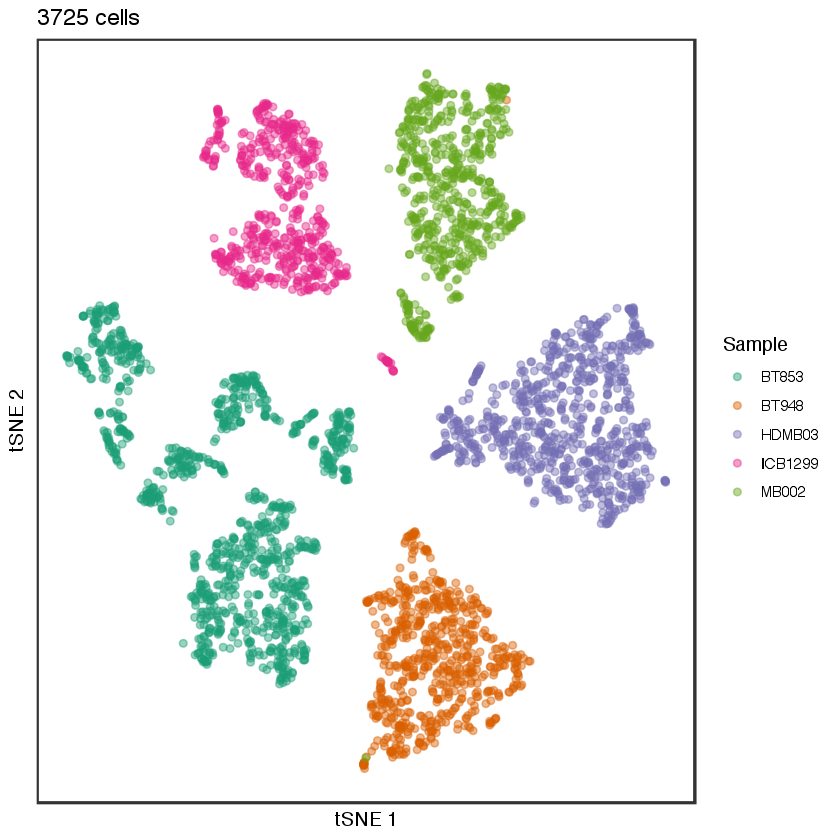

In [76]:
sp1 <- ggplot(test, aes(x=tSNE_1, y=tSNE_2, color=Sample)) + 
        geom_point(alpha = 0.45, size = 1.5) +  
        labs(x = "tSNE 1", y = "tSNE 2", title = "3725 cells") +
        scale_colour_brewer(palette = "Dark2") + 
        theme_bw() + 
        theme(axis.text.x = element_blank(), axis.text.y = element_blank(), axis.ticks = element_blank(),
              panel.border = element_rect(linetype = "solid", fill = NA, size = 1),
              panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
              panel.background = element_blank()) 

sp1



In [153]:
pdf("~/Desktop/Scoring_tSNE.pdf", height = 4, width = 5.5)

i <-  test$GSVA.scaled_Wnt_Subgroup
name <- "Wnt Subgroup \n GSVA Enrichment Score"

sp2 <- ggplot(test, aes(x=tSNE_1, y=tSNE_2, color=i)) + 
        geom_point(alpha = 0.6, size = 1.5) +  
       
         scale_colour_gradientn(colours = rev(brewer.pal(10, "Spectral")), limits = c(-0.6,0.6), name = name) +
        labs(x = "tSNE 1", y = "tSNE 2", title = "3725 cells") +
        theme_bw() + 
        theme(axis.text.x = element_blank(), axis.text.y = element_blank(), axis.ticks = element_blank(),
              panel.border = element_rect(linetype = "solid", fill = NA, size = 1),
              panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
              panel.background = element_blank())
sp2

dev.off()

pdf 
  2

In [22]:
cell.class <- cbind(Wnt_medullo@dr$tsne@cell.embeddings, df)
head(cell.class)

,tSNE_1,tSNE_2,Sample,res.0.5,AMS.ScaledData_Wnt_Subgroup,AMS.ScaledData_Shh_Subgroup,AMS.ScaledData_Group3_Subgroup,AMS.ScaledData_Group4_Subgroup,AMS.ScaledData_KEGG_Wnt_pathway,AMS.ScaledData_Canonical_Wnt_pathway,AMS.ScaledData_TGP,GSVA.scaled_Wnt_Subgroup,GSVA.scaled_Shh_Subgroup,GSVA.scaled_Group3_Subgroup,GSVA.scaled_Group4_Subgroup,GSVA.scaled_KEGG_Wnt_pathway,GSVA.scaled_Canonical_Wnt_pathway,GSVA.scaled_TGP,GSVA.scaled_common.WNT,AMS.ScaledData_common.WNT
AAACCTGAGTCAATAG.1,-13.27260,-18.111087,BT853,4,0,1,0,0,0,0,0,1,1,0,0,0,0,0,1,1
AAACCTGGTCATTAGC.1,-14.05767,-10.198292,BT853,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
AAACCTGTCATTATCC.1,-39.70283,11.645087,BT853,5,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
AAACCTGTCTTACCGC.1,-38.90888,-2.707165,BT853,6,0,1,0,1,1,1,0,0,1,0,1,0,0,0,0,1
AAACGGGGTCACCCAG.1,-25.62579,-21.698571,BT853,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
AAACGGGGTCTAGCGC.1,-44.67019,6.328698,BT853,5,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0


In [198]:
pdf("~/Desktop/Singh_tSNEs/AMS_CommonWnt_tSNE.pdf", height = 4, width = 5.5)

i <-  test$AMS.ScaledData_common.WNT
j <- cell.class$AMS.ScaledData_common.WNT
name <- "Common Wnt Pathway \n AddModuleScore()"
name2 <- "Common Wnt Pathway Classifier"

sp2 <- ggplot(test, aes(x=tSNE_1, y=tSNE_2, color=i)) + 
        geom_point(alpha = 0.6, size = 1.5) +  
       
         scale_colour_gradientn(colours = rev(brewer.pal(10, "Spectral")), limits = c(-1,1), name = name) +
        labs(x = "tSNE 1", y = "tSNE 2", title = "3725 cells") +
        theme_bw() + 
        theme(axis.text.x = element_blank(), axis.text.y = element_blank(), axis.ticks = element_blank(),
              panel.border = element_rect(linetype = "solid", fill = NA, size = 1),
              panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
              panel.background = element_blank())
sp2


sp3 <- ggplot(cell.class, aes(x=tSNE_1, y=tSNE_2, color=j)) + 
        geom_point(alpha = 0.45, size = 1.5) +  
        #scale_colour_gradientn(colours = c("darkblue", "white", "darkred"), limits = c(-1,1), name = "Wnt Subgroup Score") 
         scale_colour_gradientn(colours = c("grey", '#9E0142'), name = name2) +
        labs(x = "tSNE 1", y = "tSNE 2", title = "3725 cells") +
        theme_bw() + 
        theme(axis.text.x = element_blank(), axis.text.y = element_blank(), axis.ticks = element_blank(),
              panel.border = element_rect(linetype = "solid", fill = NA, size = 1),
              panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
              panel.background = element_blank())
sp3


sp4 <- ggplot(test, aes(x = Sample, y = i, fill = Sample)) +
        geom_boxplot(width=0.8, alpha = 0.4) +
    ylab(name) + xlab("")  + scale_fill_brewer(palette="Dark2") + theme(legend.position="none")
sp4

dev.off()


pdf 
  2

In [23]:
colnames(cell.class) <- paste0("Class", colnames(cell.class))

bb <- cbind(test, cell.class[ ,5:length(colnames(cell.class))])
head(bb)

,tSNE_1,tSNE_2,nGene,nUMI,percent.mito,Num.Reads,Sample,Subgroup,Stage,Cell.Quality,⋯,ClassAMS.ScaledData_TGP,ClassGSVA.scaled_Wnt_Subgroup,ClassGSVA.scaled_Shh_Subgroup,ClassGSVA.scaled_Group3_Subgroup,ClassGSVA.scaled_Group4_Subgroup,ClassGSVA.scaled_KEGG_Wnt_pathway,ClassGSVA.scaled_Canonical_Wnt_pathway,ClassGSVA.scaled_TGP,ClassGSVA.scaled_common.WNT,ClassAMS.ScaledData_common.WNT
AAACCTGAGTCAATAG.1,-13.27260,-18.111087,4784,29465,0.049686068,57223,BT853,WNT,Primary,1,⋯,0,1,1,0,0,0,0,0,1,1
AAACCTGGTCATTAGC.1,-14.05767,-10.198292,4068,18474,0.004492801,35775,BT853,WNT,Primary,1,⋯,0,0,0,0,0,0,0,0,1,1
AAACCTGTCATTATCC.1,-39.70283,11.645087,706,1535,0.001954397,9672,BT853,WNT,Primary,1,⋯,0,0,0,0,0,0,0,0,0,0
AAACCTGTCTTACCGC.1,-38.90888,-2.707165,2001,5328,0.235735736,15362,BT853,WNT,Primary,1,⋯,0,0,1,0,1,0,0,0,0,1
AAACGGGGTCACCCAG.1,-25.62579,-21.698571,5208,27359,0.040169597,49766,BT853,WNT,Primary,1,⋯,0,0,0,0,0,0,0,0,1,1
AAACGGGGTCTAGCGC.1,-44.67019,6.328698,2873,7758,0.140113431,39238,BT853,WNT,Primary,1,⋯,0,1,0,0,0,0,0,0,0,0


In [245]:
#number pos cells per sample
dat <-  table(bb$Sample, bb$ClassGSVA.scaled_Wnt_Subgroup)
dat

p.dat <- dat/rowSums(dat)
p.dat

pdf("~/Desktop/Singh_tSNEs/Wnt_Subgroup_proportion_GSVA.pdf")

barplot(t(dat),
        ylab = "Cell Count",
        col = c("grey", "#9E0142"),
        legend = TRUE,
        args.legend = list(x = "topright", bty = 'n', legend = c("+", "-"))
       )


barplot(t(p.dat),
        ylab = "Proportion Cells",
        col = c("grey", "#9E0142")
       )

dev.off()


         
            0   1
  BT853   865 234
  BT948   629  13
  HDMB03  747  66
  ICB1299 545   8
  MB002   615   3

         
                    0           1
  BT853   0.787079163 0.212920837
  BT948   0.979750779 0.020249221
  HDMB03  0.918819188 0.081180812
  ICB1299 0.985533454 0.014466546
  MB002   0.995145631 0.004854369

In [326]:
dat <-  table(bb$Sample, bb$ClassGSVA.scaled_common.WNT
            )
dat

         
            0   1
  BT853   300 799
  BT948   641   1
  HDMB03  813   0
  ICB1299 553   0
  MB002   617   1

In [317]:
#number pos cells per sample
dat <-  table(bb$Sample, bb$ClassGSVA.scaled_common.WNT)
dat

p.dat <- dat/rowSums(dat)
p.dat

pdf("~/Desktop/Singh_tSNEs/CommonWnt_proportion_GSVA.pdf")

barplot(t(dat),
        ylab = "Cell Count",
        col = c("grey", "#9E0142"),
        legend = TRUE,
        args.legend = list(x = "topright", bty = 'n', legend = c("+", "-"))
       )


barplot(t(p.dat),
        ylab = "Proportion Cells",
        col = c("grey", "#9E0142")
       )

dev.off()


         
            0   1
  BT853   300 799
  BT948   641   1
  HDMB03  813   0
  ICB1299 553   0
  MB002   617   1

         
                    0           1
  BT853   0.272975432 0.727024568
  BT948   0.998442368 0.001557632
  HDMB03  1.000000000 0.000000000
  ICB1299 1.000000000 0.000000000
  MB002   0.998381877 0.001618123

pdf 
  2

---
## Look at TGP+ vs - cells
---


TGP+ cells should have reduced BMi1 ad Sox2 transcripts, Axin2
This does not really make sense. I think we should look at active Wnt signature in these cells instead.



In [309]:
#get barcodes of cells for TGP+ and TGP -
library(gridExtra)

p <- ggplot(B, aes(x = as.character(B$ClassGSVA.scaled_TGP), y = B$BMI1, fill = as.character(B$ClassGSVA.scaled_TGP))) +
        geom_violin(trim = TRUE, alpha = 0.8) +
        stat_summary(fun.y=mean, geom="point", size=2, color="black") +
        ylab("BMI1 Expression") + xlab("")  + scale_fill_manual(values=(c("grey", "#9E0142"))) +
        theme(legend.position="none")
#p


q <- ggplot(B, aes(x = as.character(B$ClassGSVA.scaled_TGP), y = B$SOX2, fill = as.character(B$ClassGSVA.scaled_TGP))) +
        geom_violin(trim = TRUE, alpha = 0.8) +
        stat_summary(fun.y=mean, geom="point", size=2, color="black") +
        ylab("SOX2 Expression") + xlab("")  + scale_fill_manual(values=(c("grey", "#9E0142"))) +
        theme(legend.position="none")
#q

r <- ggplot(B, aes(x = as.character(B$ClassGSVA.scaled_TGP), y = B$AXIN2, fill = as.character(B$ClassGSVA.scaled_TGP))) +
        geom_violin(trim = TRUE, alpha = 0.8) +
        stat_summary(fun.y=mean, geom="point", size=2, color="black") +
        ylab("AXIN2 Expression") + xlab("")  + scale_fill_manual(values=(c("grey", "#9E0142"))) +
        theme(legend.position="none")

#r

pdf("~/Desktop/Singh_tSNEs/TGP_geneExpression.pdf", height = 3, width = 10)
grid.arrange(p,q,r, ncol = 3)
dev.off()

pdf 
  2

In [34]:
B <- Wnt_medullo@scale.data[rownames(Wnt_medullo@scale.data) %in% c("BMI1", "SOX2", "AXIN2"), ]
B <- as.matrix(t(B))
head(B)
str(B)

B <- cbind(B, bb)
head(B)

str()

,SOX2,BMI1,AXIN2
AAACCTGAGTCAATAG.1,-0.3214374,-0.6348695,-0.1570402
AAACCTGGTCATTAGC.1,-0.3214374,-0.6348695,-0.1570402
AAACCTGTCATTATCC.1,-0.3214374,-0.6348695,-0.1570402
AAACCTGTCTTACCGC.1,-0.3214374,-0.6348695,-0.1570402
AAACGGGGTCACCCAG.1,-0.3214374,1.0472631,-0.1570402
AAACGGGGTCTAGCGC.1,-0.3214374,-0.6348695,-0.1570402


 num [1:3725, 1:3] -0.321 -0.321 -0.321 -0.321 -0.321 ...
 - attr(*, "dimnames")=List of 2
  ..$ : chr [1:3725] "AAACCTGAGTCAATAG.1" "AAACCTGGTCATTAGC.1" "AAACCTGTCATTATCC.1" "AAACCTGTCTTACCGC.1" ...
  ..$ : chr [1:3] "SOX2" "BMI1" "AXIN2"


,SOX2,BMI1,AXIN2,tSNE_1,tSNE_2,nGene,nUMI,percent.mito,Num.Reads,Sample,⋯,ClassAMS.ScaledData_TGP,ClassGSVA.scaled_Wnt_Subgroup,ClassGSVA.scaled_Shh_Subgroup,ClassGSVA.scaled_Group3_Subgroup,ClassGSVA.scaled_Group4_Subgroup,ClassGSVA.scaled_KEGG_Wnt_pathway,ClassGSVA.scaled_Canonical_Wnt_pathway,ClassGSVA.scaled_TGP,ClassGSVA.scaled_common.WNT,ClassAMS.ScaledData_common.WNT
AAACCTGAGTCAATAG.1,-0.3214374,-0.6348695,-0.1570402,-13.27260,-18.111087,4784,29465,0.049686068,57223,BT853,⋯,0,1,1,0,0,0,0,0,1,1
AAACCTGGTCATTAGC.1,-0.3214374,-0.6348695,-0.1570402,-14.05767,-10.198292,4068,18474,0.004492801,35775,BT853,⋯,0,0,0,0,0,0,0,0,1,1
AAACCTGTCATTATCC.1,-0.3214374,-0.6348695,-0.1570402,-39.70283,11.645087,706,1535,0.001954397,9672,BT853,⋯,0,0,0,0,0,0,0,0,0,0
AAACCTGTCTTACCGC.1,-0.3214374,-0.6348695,-0.1570402,-38.90888,-2.707165,2001,5328,0.235735736,15362,BT853,⋯,0,0,1,0,1,0,0,0,0,1
AAACGGGGTCACCCAG.1,-0.3214374,1.0472631,-0.1570402,-25.62579,-21.698571,5208,27359,0.040169597,49766,BT853,⋯,0,0,0,0,0,0,0,0,1,1
AAACGGGGTCTAGCGC.1,-0.3214374,-0.6348695,-0.1570402,-44.67019,6.328698,2873,7758,0.140113431,39238,BT853,⋯,0,1,0,0,0,0,0,0,0,0


ERROR: Error in str.default(): argument "object" is missing, with no default


In [30]:
head(B)

,SOX2,BMI1,AXIN2,tSNE_1,tSNE_2,nGene,nUMI,percent.mito,Num.Reads,Sample,⋯,ClassAMS.ScaledData_TGP,ClassGSVA.scaled_Wnt_Subgroup,ClassGSVA.scaled_Shh_Subgroup,ClassGSVA.scaled_Group3_Subgroup,ClassGSVA.scaled_Group4_Subgroup,ClassGSVA.scaled_KEGG_Wnt_pathway,ClassGSVA.scaled_Canonical_Wnt_pathway,ClassGSVA.scaled_TGP,ClassGSVA.scaled_common.WNT,ClassAMS.ScaledData_common.WNT
AAACCTGAGTCAATAG.1,0,0.0000000,0,-13.27260,-18.111087,4784,29465,0.049686068,57223,BT853,⋯,0,1,1,0,0,0,0,0,1,1
AAACCTGGTCATTAGC.1,0,0.0000000,0,-14.05767,-10.198292,4068,18474,0.004492801,35775,BT853,⋯,0,0,0,0,0,0,0,0,1,1
AAACCTGTCATTATCC.1,0,0.0000000,0,-39.70283,11.645087,706,1535,0.001954397,9672,BT853,⋯,0,0,0,0,0,0,0,0,0,0
AAACCTGTCTTACCGC.1,0,0.0000000,0,-38.90888,-2.707165,2001,5328,0.235735736,15362,BT853,⋯,0,0,1,0,1,0,0,0,0,1
AAACGGGGTCACCCAG.1,0,0.5487576,0,-25.62579,-21.698571,5208,27359,0.040169597,49766,BT853,⋯,0,0,0,0,0,0,0,0,1,1
AAACGGGGTCTAGCGC.1,0,0.0000000,0,-44.67019,6.328698,2873,7758,0.140113431,39238,BT853,⋯,0,1,0,0,0,0,0,0,0,0


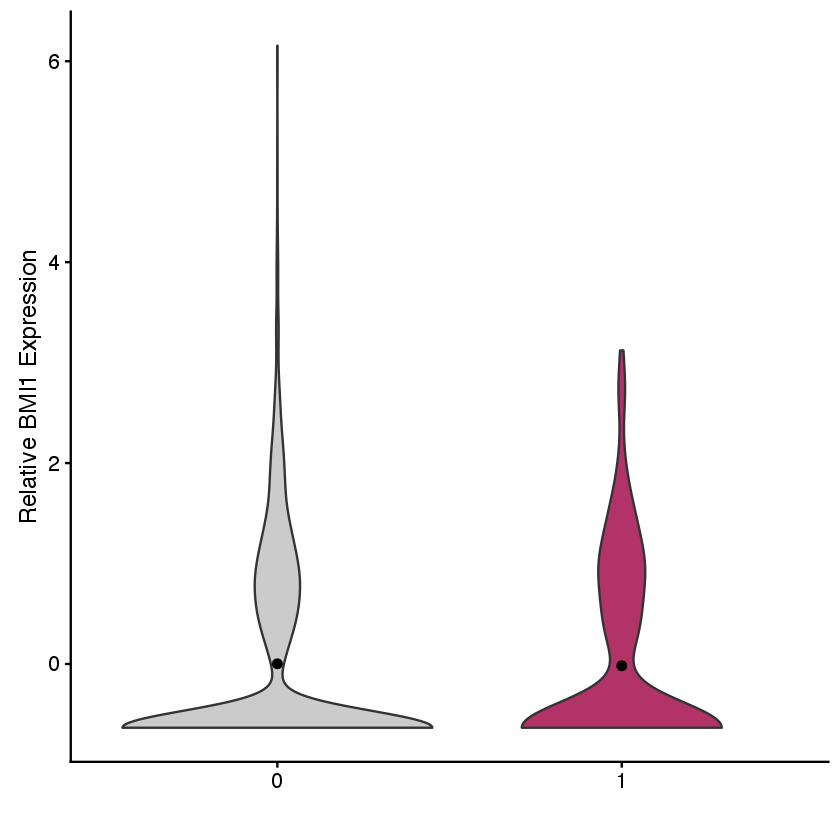

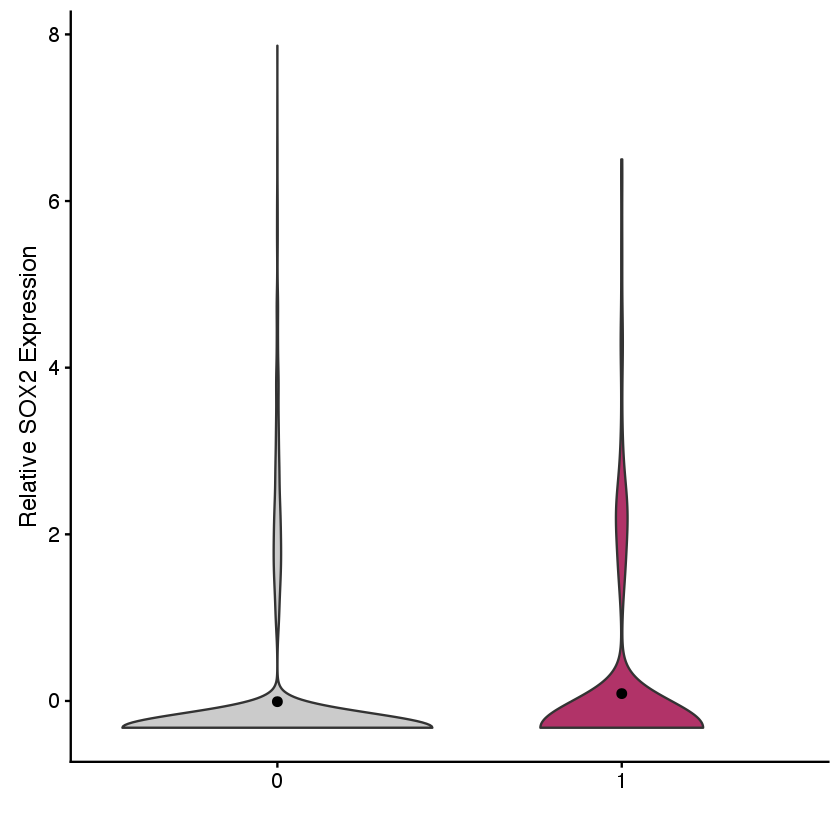

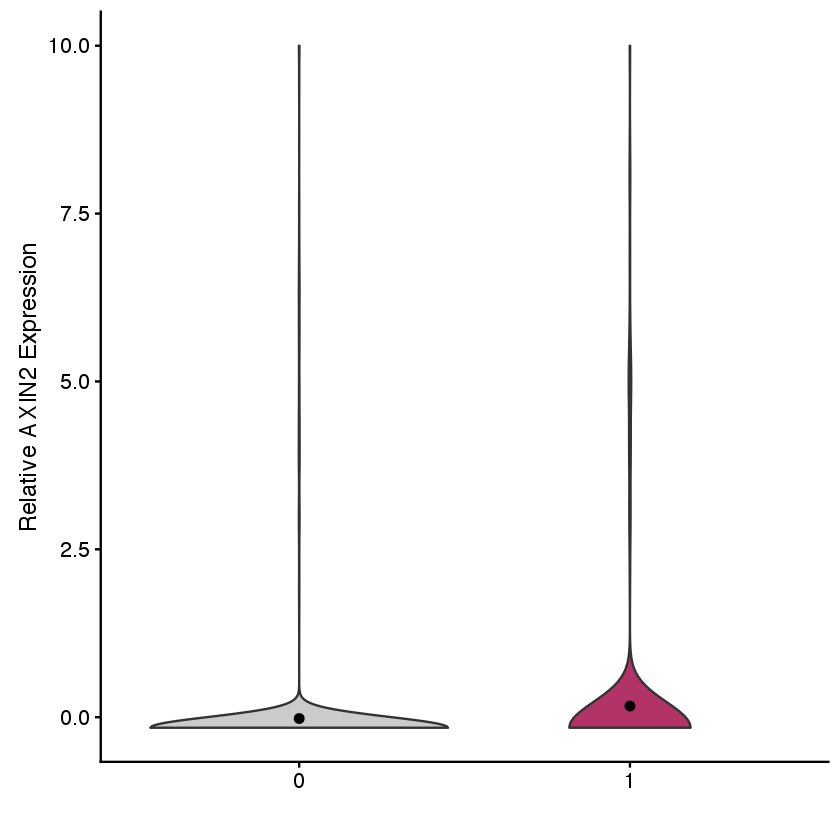

In [37]:
p <- ggplot(B, aes(x = as.character(B$ClassGSVA.scaled_Wnt_Subgroup), y = B$BMI1, fill = as.character(B$ClassGSVA.scaled_Wnt_Subgroup))) +
        geom_violin(trim = TRUE, alpha = 0.8) +
        stat_summary(fun.y=mean, geom="point", size=2, color="black") +
        ylab("Relative BMI1 Expression") + xlab("")  + scale_fill_manual(values=(c("grey", "#9E0142"))) +
        theme(legend.position="none")
p  


q <- ggplot(B, aes(x = as.character(B$ClassGSVA.scaled_Wnt_Subgroup), y = B$SOX2, fill = as.character(B$ClassGSVA.scaled_Wnt_Subgroup))) +
        geom_violin(trim = TRUE, alpha = 0.8) +
        stat_summary(fun.y=mean, geom="point", size=2, color="black") +
        ylab("Relative SOX2 Expression") + xlab("")  + scale_fill_manual(values=(c("grey", "#9E0142"))) +
        theme(legend.position="none")
q

q <- ggplot(B, aes(x = as.character(B$ClassGSVA.scaled_Wnt_Subgroup), y = B$AXIN2, fill = as.character(B$ClassGSVA.scaled_Wnt_Subgroup))) +
        geom_violin(trim = TRUE, alpha = 0.8) +
        stat_summary(fun.y=mean, geom="point", size=2, color="black") +
        ylab("Relative AXIN2 Expression") + xlab("")  + scale_fill_manual(values=(c("grey", "#9E0142"))) +
        theme(legend.position="none")
q

### Instead of the TPG Signature - use the Wnt signature from Owen

In [316]:
library(gridExtra)

p <- ggplot(B, aes(x = as.character(B$ClassGSVA.scaled_common.WNT), y = B$BMI1, fill = as.character(B$ClassGSVA.scaled_common.WNT))) +
        geom_violin(trim = TRUE, alpha = 0.8) +
        stat_summary(fun.y=mean, geom="point", size=2, color="black") +
        ylab("BMI1 Expression") + xlab("")  + scale_fill_manual(values=(c("grey", "#9E0142"))) +
        theme(legend.position="none")
#p


q <- ggplot(B, aes(x = as.character(B$ClassGSVA.scaled_common.WNT), y = B$SOX2, fill = as.character(B$ClassGSVA.scaled_common.WNT))) +
        geom_violin(trim = TRUE, alpha = 0.8) +
        stat_summary(fun.y=mean, geom="point", size=2, color="black") +
        ylab("SOX2 Expression") + xlab("")  + scale_fill_manual(values=(c("grey", "#9E0142"))) +
        theme(legend.position="none")
#q

r <- ggplot(B, aes(x = as.character(B$ClassGSVA.scaled_common.WNT), y = B$AXIN2, fill = as.character(B$ClassGSVA.scaled_common.WNT))) +
        geom_violin(trim = TRUE, alpha = 0.8) +
        stat_summary(fun.y=mean, geom="point", size=2, color="black") +
        ylab("AXIN2 Expression") + xlab("")  + scale_fill_manual(values=(c("grey", "#9E0142"))) +
        theme(legend.position="none")

#r

pdf("~/Desktop/Singh_tSNEs/CommonWnt_geneExpression.pdf", height = 3, width = 10)
grid.arrange(p,q,r, ncol = 3)
dev.off()

pdf 
  2

In [313]:
head(B)

,SOX2,BMI1,AXIN2,tSNE_1,tSNE_2,nGene,nUMI,percent.mito,Num.Reads,Sample,⋯,ClassAMS.ScaledData_TGP,ClassGSVA.scaled_Wnt_Subgroup,ClassGSVA.scaled_Shh_Subgroup,ClassGSVA.scaled_Group3_Subgroup,ClassGSVA.scaled_Group4_Subgroup,ClassGSVA.scaled_KEGG_Wnt_pathway,ClassGSVA.scaled_Canonical_Wnt_pathway,ClassGSVA.scaled_TGP,ClassGSVA.scaled_common.WNT,ClassAMS.ScaledData_common.WNT
AAACCTGAGTCAATAG.1,0,0.0000000,0,-13.27260,-18.111087,4784,29465,0.049686068,57223,BT853,⋯,0,1,1,0,0,0,0,0,1,1
AAACCTGGTCATTAGC.1,0,0.0000000,0,-14.05767,-10.198292,4068,18474,0.004492801,35775,BT853,⋯,0,0,0,0,0,0,0,0,1,1
AAACCTGTCATTATCC.1,0,0.0000000,0,-39.70283,11.645087,706,1535,0.001954397,9672,BT853,⋯,0,0,0,0,0,0,0,0,0,0
AAACCTGTCTTACCGC.1,0,0.0000000,0,-38.90888,-2.707165,2001,5328,0.235735736,15362,BT853,⋯,0,0,1,0,1,0,0,0,0,1
AAACGGGGTCACCCAG.1,0,0.5487576,0,-25.62579,-21.698571,5208,27359,0.040169597,49766,BT853,⋯,0,0,0,0,0,0,0,0,1,1
AAACGGGGTCTAGCGC.1,0,0.0000000,0,-44.67019,6.328698,2873,7758,0.140113431,39238,BT853,⋯,0,1,0,0,0,0,0,0,0,0


---
# 11.0 Replot QC Metrics of High Quality Cells
---

Use same colours for samples as those in the tSNE

scale_colour_brewer(palette = "Dark2")

In [ ]:
pdf("~/Desktop/Singh_QC_Jan92018.pdf", width = 5, height = 5)

genes <- ggplot(Wnt_medullo@meta.data, aes(x = Sample, y = nGene, fill = Sample)) +
     geom_violin(trim = TRUE, alpha = 0.4) +
        geom_boxplot(width=0.05, outlier.shape = NA) +
    ylim (c(0, 8000)) +
    ylab("Genes") + xlab("")  + scale_fill_brewer(palette="Dark2") +
theme(legend.position="none")

genes

UMIs <- ggplot(Wnt_medullo@meta.data, aes(x = Sample, y = nUMI, fill = Sample)) +
     geom_violin(trim = TRUE, alpha = 0.4) +
        geom_boxplot(width=0.05, outlier.shape = NA) +
    ylim (c(0, 80000)) +
    ylab("UMIs") + xlab("")  + scale_fill_brewer(palette="Dark2") +
theme(legend.position="none")

UMIs

mito <- ggplot(Wnt_medullo@meta.data, aes(x = Sample, y = percent.mito, fill = Sample)) +
     geom_violin(trim = TRUE, alpha = 0.4) +
        geom_boxplot(width=0.05, outlier.shape = NA) +
    ylim (c(0, 0.3)) +
    ylab("Proportion Mitochondrial UMIs") + xlab("")  + scale_fill_brewer(palette="Dark2") +
theme(legend.position="none")

mito

reads <- ggplot(Wnt_medullo@meta.data, aes(x = Sample, y = Num.Reads, fill = Sample )) +
     geom_violin(trim = TRUE, alpha = 0.4) +
        geom_boxplot(width=0.05, outlier.shape = NA) +
    #ylim (c(0, 0.3)) +
    ylab("Reads") + xlab("")  + scale_fill_brewer(palette="Dark2") +
theme(legend.position="none")

reads

dev.off()

In [ ]:
#dat <- Wnt_medullo@meta.data[Wnt_medullo@meta.data$Sample == "MB002", ]
#median(dat$Num.Reads)

In [322]:
load("~/Desktop/Samwise/projects/SinghLab_scMedullo/data/geneSets_SinghLab.Rdata")

In [323]:
str(gene.sets)

List of 8
 $ Wnt_Subgroup         : chr [1:26] "EPHA7" "FZD10" "BMP4" "WNT16" ...
 $ Shh_Subgroup         : chr [1:40] "DYRK1B" "ARRB2" "GLI2" "GLI3" ...
 $ Group3_Subgroup      : chr [1:14] "GNB3" "GNGT1" "RCVRN" "PDE6H" ...
 $ Group4_Subgroup      : chr [1:26] "ARHGEF12" "RND1" "RHOT1" "DPYSL4" ...
 $ KEGG_Wnt_pathway     : chr [1:151] "APC" "APC2" "AXIN1" "AXIN2" ...
 $ Canonical_Wnt_pathway: chr [1:55] "WNT1" "WNT10A" "WNT16" "WNT2" ...
 $ TGP                  : chr [1:6] "PLPP2" "S100A11" "KCNC3" "HRH3" ...
 $ common.WNT           : chr [1:197] "PARP10" "NES" "VIM" "TSC22D3" ...


---
## Replot Wnt Subgroup Heatmap with new data and scoring methods
---

Replot the heatmap with GSVA enrichment score as the top row and then the scaled gene expression as the bottom row. 

In [6]:
suppressMessages(library(pheatmap))
suppressMessages(library(RColorBrewer))
suppressMessages(library(viridis))
suppressMessages(library(scales))
suppressMessages(library(Seurat))

Warning message:
“package ‘viridis’ was built under R version 3.4.4”Warning message:
“package ‘viridisLite’ was built under R version 3.4.3”Warning message:
“package ‘scales’ was built under R version 3.4.4”

In [1]:
#load gene sets
load("~/Desktop/Samwise/projects/SinghLab_scMedullo/data/geneSets_SinghLab.Rdata")

#load data
load("~/Desktop/Samwise/projects/SinghLab_scMedullo/AddModuleScore/WntMedullo_newQC_scoring.RData")

In [9]:
colnames(Wnt_medullo@meta.data)
Wnt_subgroup <- gene.sets[[1]]
Wnt_subgroup

[1] "nGene"                               
 [2] "nUMI"                                
 [3] "percent.mito"                        
 [4] "Num.Reads"                           
 [5] "Sample"                              
 [6] "Subgroup"                            
 [7] "Stage"                               
 [8] "Cell.Quality"                        
 [9] "orig.ident"                          
[10] "res.0.2"                             
[11] "res.0.3"                             
[12] "res.0.4"                             
[13] "res.0.5"                             
[14] "res.0.6"                             
[15] "res.0.7"                             
[16] "res.0.8"                             
[17] "res.0.9"                             
[18] "res.1"                               
[19] "AMS_Wnt_Subgroup"                    
[20] "AMS_Shh_Subgroup"                    
[21] "AMS_Group3_Subgroup"                 
[22] "AMS_Group4_Subgroup"                 
[23] "AMS_KEGG_Wnt_pathway"                
[24] "AMS_Canonical_Wnt_pathway"           
[25] "AMS_TGP"                             
[26] "AMS.ScaledData_Wnt_Subgroup"         
[27] "AMS.ScaledData_Shh_Subgroup"         
[28] "AMS.ScaledData_Group3_Subgroup"      
[29] "AMS.ScaledData_Group4_Subgroup"      
[30] "AMS.ScaledData_KEGG_Wnt_pathway"     
[31] "AMS.ScaledData_Canonical_Wnt_pathway"
[32] "AMS.ScaledData_TGP"                  
[33] "GSVA.scaled_Wnt_Subgroup"            
[34] "GSVA.scaled_Shh_Subgroup"            
[35] "GSVA.scaled_Group3_Subgroup"         
[36] "GSVA.scaled_Group4_Subgroup"         
[37] "GSVA.scaled_KEGG_Wnt_pathway"        
[38] "GSVA.scaled_Canonical_Wnt_pathway"   
[39] "GSVA.scaled_TGP"                     
[40] "GSVA_Wnt_Subgroup"                   
[41] "GSVA_Shh_Subgroup"                   
[42] "GSVA_Group3_Subgroup"                
[43] "GSVA_Group4_Subgroup"                
[44] "GSVA_KEGG_Wnt_pathway"               
[45] "GSVA_Canonical_Wnt_pathway"          
[46] "GSVA_TGP"                            
[47] "GSVA.scaled_common.WNT"              
[48] "AMS.ScaledData_common.WNT"

[1] "EPHA7"   "FZD10"   "BMP4"    "WNT16"   "EPHA4"   "NFATC4"  "SLIT2"  
 [8] "EPHA3"   "ADAM12"  "PRKCD"   "FZD6"    "ADAM19"  "PLCB1"   "SEMA3B" 
[15] "AXIN2"   "WIF1"    "DKK4"    "DKK2"    "LEF1"    "KREMEN1" "DKK1"   
[22] "GLT8D2"  "GALNT7"  "GALNT14" "GALNT12" "GALNTL2"

In [29]:
#define gene signature specific expression matrix

mat <- Wnt_medullo@scale.data[rownames(Wnt_medullo@scale.data) %in% Wnt_subgroup,]
dim(mat)
mat[1:5, 1:5]
max(mat)
min(mat)

#crush the scale for scaled Data
mat[mat > 3] <- 3
mat[mat < (-3)] <- -3
max(mat)
min(mat)

[1]   23 3725

,AAACCTGAGTCAATAG.1,AAACCTGGTCATTAGC.1,AAACCTGTCATTATCC.1,AAACCTGTCTTACCGC.1,AAACGGGGTCACCCAG.1
GALNT14,-0.36606930,-0.36606930,-0.36606930,-0.36606930,-0.36606930
EPHA4,-0.16639358,-0.16639358,-0.16639358,-0.16639358,-0.16639358
SEMA3B,-0.07955669,-0.07955669,-0.07955669,-0.07955669,-0.07955669
PRKCD,-0.15093435,-0.15093435,-0.15093435,-0.15093435,-0.15093435
EPHA3,-0.07601977,-0.07601977,-0.07601977,-0.07601977,-0.07601977


[1] 10

[1] -0.4107764

[1] 3

[1] -0.4107764

In [30]:
#combine data with GSVA scoring data

mat <- rbind(mat, 
             Wnt_medullo@meta.data$GSVA.scaled_Wnt_Subgroup
            )
dim(mat)
head(mat)

[1]   24 3725

,AAACCTGAGTCAATAG.1,AAACCTGGTCATTAGC.1,AAACCTGTCATTATCC.1,AAACCTGTCTTACCGC.1,AAACGGGGTCACCCAG.1,AAACGGGGTCTAGCGC.1,AAACGGGTCCGCATCT.1,AAAGATGAGGTGTGGT.1,AAAGATGCATACCATG.1,AAAGATGCATGTCTCC.1,⋯,TTTCCTCAGTACCGGA.5,TTTCCTCCAACGATGG.5,TTTCCTCGTAACGACG.5,TTTCCTCGTGAGGCTA.5,TTTCCTCTCAGTCCCT.5,TTTGCGCCAGTCTTCC.5,TTTGCGCCATTGGCGC.5,TTTGCGCTCTTGCATT.5,TTTGGTTCACAACTGT.5,TTTGTCATCGTATCAG.5
GALNT14,-0.36606930,-0.36606930,-0.36606930,-0.36606930,-0.36606930,-0.36606930,-0.36606930,-0.36606930,-0.36606930,-0.36606930,⋯,-0.36606930,-0.36606930,-0.36606930,2.81991514,-0.36606930,-0.36606930,-0.36606930,-0.36606930,-0.36606930,0.65804827
EPHA4,-0.16639358,-0.16639358,-0.16639358,-0.16639358,-0.16639358,-0.16639358,-0.16639358,-0.16639358,-0.16639358,-0.16639358,⋯,-0.16639358,-0.16639358,-0.16639358,-0.16639358,-0.16639358,-0.16639358,-0.16639358,3.00000000,-0.16639358,-0.16639358
SEMA3B,-0.07955669,-0.07955669,-0.07955669,-0.07955669,-0.07955669,-0.07955669,-0.07955669,-0.07955669,-0.07955669,-0.07955669,⋯,-0.07955669,-0.07955669,-0.07955669,-0.07955669,-0.07955669,-0.07955669,-0.07955669,-0.07955669,-0.07955669,-0.07955669
PRKCD,-0.15093435,-0.15093435,-0.15093435,-0.15093435,-0.15093435,-0.15093435,-0.15093435,-0.15093435,-0.15093435,-0.15093435,⋯,-0.15093435,-0.15093435,3.00000000,-0.15093435,-0.15093435,-0.15093435,-0.15093435,-0.15093435,-0.15093435,-0.15093435
EPHA3,-0.07601977,-0.07601977,-0.07601977,-0.07601977,-0.07601977,-0.07601977,-0.07601977,-0.07601977,-0.07601977,-0.07601977,⋯,-0.07601977,-0.07601977,-0.07601977,-0.07601977,-0.07601977,-0.07601977,3.00000000,-0.07601977,-0.07601977,-0.07601977
SLIT2,-0.16795525,-0.16795525,-0.16795525,-0.16795525,-0.16795525,-0.16795525,-0.16795525,-0.16795525,-0.16795525,-0.16795525,⋯,-0.16795525,-0.16795525,-0.16795525,-0.16795525,-0.16795525,-0.16795525,-0.16795525,-0.16795525,-0.16795525,-0.16795525


In [31]:
row.names(mat)[24] <- c("Wnt_Subgroup"                          
                           )

In [34]:
BT853 <- mat[,(Wnt_medullo@meta.data$Sample == "BT853")]
head(BT853)
col_order <- order(BT853[rownames(BT853) == "Wnt_Subgroup",])
#col_order
BT853 <- BT853[ ,col_order]

mat_ordered <- BT853[match(row_order, rownames(BT853)),]
dim(mat_ordered)

,AAACCTGAGTCAATAG.1,AAACCTGGTCATTAGC.1,AAACCTGTCATTATCC.1,AAACCTGTCTTACCGC.1,AAACGGGGTCACCCAG.1,AAACGGGGTCTAGCGC.1,AAACGGGTCCGCATCT.1,AAAGATGAGGTGTGGT.1,AAAGATGCATACCATG.1,AAAGATGCATGTCTCC.1,⋯,TTTCCTCGTTGAGTTC.1,TTTCCTCTCTAACTCT.1,TTTGCGCAGACATAAC.1,TTTGCGCCAGGTGCCT.1,TTTGCGCTCATACGGT.1,TTTGCGCTCCAGATCA.1,TTTGCGCTCCCTAACC.1,TTTGGTTCACCATGTA.1,TTTGGTTGTTGCTCCT.1,TTTGTCACACATGGGA.1
GALNT14,-0.36606930,-0.36606930,-0.36606930,-0.36606930,-0.36606930,-0.36606930,-0.36606930,-0.36606930,-0.36606930,-0.36606930,⋯,-0.36606930,-0.36606930,-0.36606930,-0.36606930,-0.36606930,-0.36606930,-0.36606930,-0.36606930,-0.36606930,-0.36606930
EPHA4,-0.16639358,-0.16639358,-0.16639358,-0.16639358,-0.16639358,-0.16639358,-0.16639358,-0.16639358,-0.16639358,-0.16639358,⋯,-0.16639358,-0.16639358,-0.16639358,-0.16639358,-0.16639358,-0.16639358,-0.16639358,-0.16639358,-0.16639358,-0.16639358
SEMA3B,-0.07955669,-0.07955669,-0.07955669,-0.07955669,-0.07955669,-0.07955669,-0.07955669,-0.07955669,-0.07955669,-0.07955669,⋯,-0.07955669,-0.07955669,-0.07955669,-0.07955669,-0.07955669,-0.07955669,-0.07955669,-0.07955669,-0.07955669,-0.07955669
PRKCD,-0.15093435,-0.15093435,-0.15093435,-0.15093435,-0.15093435,-0.15093435,-0.15093435,-0.15093435,-0.15093435,-0.15093435,⋯,-0.15093435,-0.15093435,-0.15093435,-0.15093435,-0.15093435,-0.15093435,-0.15093435,-0.15093435,-0.15093435,-0.15093435
EPHA3,-0.07601977,-0.07601977,-0.07601977,-0.07601977,-0.07601977,-0.07601977,-0.07601977,-0.07601977,-0.07601977,-0.07601977,⋯,-0.07601977,-0.07601977,-0.07601977,-0.07601977,-0.07601977,-0.07601977,-0.07601977,-0.07601977,-0.07601977,-0.07601977
SLIT2,-0.16795525,-0.16795525,-0.16795525,-0.16795525,-0.16795525,-0.16795525,-0.16795525,-0.16795525,-0.16795525,-0.16795525,⋯,-0.16795525,-0.16795525,-0.16795525,-0.16795525,-0.16795525,-0.16795525,-0.16795525,-0.16795525,-0.16795525,-0.16795525


In [44]:
row_order <- c('Wnt_Subgroup',
               Wnt_subgroup
           )
row_order

mat_ordered <- BT853[match(row_order, rownames(BT853)),]
dim(mat_ordered)

mat_ordered <- mat_ordered[-c(17:18,27), ]

[1] "Wnt_Subgroup" "EPHA7"        "FZD10"        "BMP4"         "WNT16"       
 [6] "EPHA4"        "NFATC4"       "SLIT2"        "EPHA3"        "ADAM12"      
[11] "PRKCD"        "FZD6"         "ADAM19"       "PLCB1"        "SEMA3B"      
[16] "AXIN2"        "WIF1"         "DKK4"         "DKK2"         "LEF1"        
[21] "KREMEN1"      "DKK1"         "GLT8D2"       "GALNT7"       "GALNT14"     
[26] "GALNT12"      "GALNTL2"

[1]   27 1099

In [46]:
samples <- c("HDMB03", "MB002", "BT948", "ICB1299")


In [48]:
for (i in 1:length(samples)){
    
    print(samples[i])
    df <- mat[,(Wnt_medullo@meta.data$Sample == samples[i])]
    col_order <- order(df[rownames(df) == "Wnt_Subgroup",]) #order cells by Wnt signature
    df <- df[ ,col_order]

    row_order <- c('Wnt_Subgroup',
               Wnt_subgroup
           )
    row_order
    
    df <- df[match(row_order, rownames(df)),]
    print(dim(df))

    df <- df[-c(17:18,27), ]

    mat_ordered <- cbind(mat_ordered, df)
    
    
}

[1] "HDMB03"
[1]  27 813
[1] "MB002"
[1]  27 618
[1] "BT948"
[1]  27 642
[1] "ICB1299"
[1]  27 553


In [86]:
breaks <- c(1099, 
            (1099+813),
            (1099+813+618),
            (1099+813+618+642),
            (1099+813+618+642+553)   
           )
breaks
breaksList <- seq(-3, 3, by = 0.25) 

row_breaks <- c(3,4)

[1] 1099 1912 2530 3172 3725

In [76]:
colnames(Wnt_medullo@meta.data)[33]

[1] "GSVA.scaled_Wnt_Subgroup"

In [82]:
#add the GSVA scores as an annotation

annotat <- Wnt_medullo@meta.data
#head(annotat)
mat_col <- annotat[ ,c(5:7)]
head(mat_col)

,Sample,Subgroup,Stage
AAACCTGAGTCAATAG.1,BT853,WNT,Primary
AAACCTGGTCATTAGC.1,BT853,WNT,Primary
AAACCTGTCATTATCC.1,BT853,WNT,Primary
AAACCTGTCTTACCGC.1,BT853,WNT,Primary
AAACGGGGTCACCCAG.1,BT853,WNT,Primary
AAACGGGGTCTAGCGC.1,BT853,WNT,Primary


In [84]:
mat_colors <- list(Sample = brewer.pal(5, "Dark2"),
                   
                   Subgroup = c("#a6611a",
                                "#80cdc1",
                                "#dfc27d"
                                ),
                   
                   Stage = c("grey", "black")
                   
    
                  )
                   

names(mat_colors$Sample) <- unique(mat_col$Sample)
names(mat_colors$Subgroup) <- unique(mat_col$Subgroup)
names(mat_colors$Stage) <- unique(mat_col$Stage)

mat_colors

$Sample
    BT853     BT948    HDMB03   ICB1299     MB002 
"#1B9E77" "#D95F02" "#7570B3" "#E7298A" "#66A61E" 

$Subgroup
      WNT      GR_4      GR_3 
"#a6611a" "#80cdc1" "#dfc27d" 

$Stage
  Primary Recurrent 
   "grey"   "black"

In [94]:
pheatmap(mat = mat_ordered,
         border_color = NA,
         color = colorRampPalette(rev(brewer.pal(10, "Spectral")))(length(GSVA_breaks)),
         show_colnames = FALSE,
         show_rownames = TRUE,
         annotation_col = mat_col,
         #annotation_row = annotat_row,
         annotation_colors = mat_colors,
         drop_levels = TRUE,
         fontsize = 8,
         main = "",
         cluster_rows = FALSE,
         cluster_cols = FALSE,
         gaps_col = breaks,
         breaks = GSVA_breaks,
         #gaps_row = row_breaks,
         annotation_names_row = FALSE,
         legend = TRUE,
         annotation_legend = TRUE,
         filename = "~/Desktop/Wnt_subgroup_GSVA.pdf"
)

In [91]:
GSVA_breaks <- seq(-0.6, 0.6, by = 0.05)

 colorRampPalette(rev(brewer.pal(10, "Spectral")))(length(GSVA_breaks))


[1] "#5E4FA2" "#4D64AC" "#3D79B6" "#388FBA" "#4CA4B1" "#5FBAA8" "#77C8A4"
 [8] "#91D2A4" "#ABDDA4" "#C1E69F" "#D7EF9B" "#E9F296" "#F2EA91" "#FBE28C"
[15] "#FDD380" "#FDC070" "#FDAE61" "#F99555" "#F67D4A" "#F06744" "#E45549"
[22] "#D8434D" "#C72E4B" "#B21746" "#9E0142"